In [339]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from itertools import cycle
import shap
from sklearn.inspection import permutation_importance
from bayes_opt import BayesianOptimization
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from rfpimp import plot_corr_heatmap, feature_dependence_matrix, plot_dependence_heatmap

# Read Datasets

In [340]:
data = pd.read_csv('dataset/All_Flows.csv')

In [341]:
data['label'].value_counts()

benign                     783574
port_scan                  160003
infiltration_dropbox_p2     63413
ddos                        45480
dos_hulk                    14108
dos_goldeneye                7574
dos_slowhttptest             4217
ftp_patator                  3993
dos_slowloris                3895
ssh_patator                  2979
webattack_bruteforce         1365
botnet                       1226
webattack_xss                 679
webattack_sqli                 12
infiltration_meta               4
heartbleed                      1
infiltration_cooldisk           1
infiltration_dropbox_p1         1
Name: label, dtype: int64

In [342]:
# Remove 'webattack_sqli', 'infiltration_meta', 'infiltration_dropbox_p1', 'heartbleed', 'infiltration_cooldisk
data = data[~data['label'].isin(['webattack_sqli', 'infiltration_meta', 'infiltration_dropbox_p1', 'heartbleed', 'infiltration_cooldisk'])]

In [343]:
df = data.copy()

In [344]:
df['label'].value_counts()

benign                     783574
port_scan                  160003
infiltration_dropbox_p2     63413
ddos                        45480
dos_hulk                    14108
dos_goldeneye                7574
dos_slowhttptest             4217
ftp_patator                  3993
dos_slowloris                3895
ssh_patator                  2979
webattack_bruteforce         1365
botnet                       1226
webattack_xss                 679
Name: label, dtype: int64

- Grouping similar attacks

In [345]:
# No longer needed

def group_label(label: str):
    if 'infiltration' in label:
        return 'infiltration'
    elif 'webattack' in label:
        return 'web attack'
    else:
        return label


# Data Exploration

In [346]:
# df = pd.concat([df_benign, df_botnet, df_portscan, df_ddos], axis=0)
# Remove Empty FLOW IDS
mask = ~df[['sport', 'src_ip', 'dst_port', 'dst_ip']].isnull().any(axis=1)

# Apply the mask to filter rows
df = df[mask]

- Flow id needs to be unique? => Not necessarily, same machine can be used in different attacks

In [347]:
# Create Flow ID Column
df['sport'] = df['sport'].astype(int).astype(str)
df['dst_port'] = df['dst_port'].astype(int).astype(str)
df['flow_id'] = df['src_ip'] + '-' + df['dst_ip'] + '-' + df['sport'] + '-' + df['dst_port']

In [348]:
# Count numple of flow ids duplicates
df['count_flow_id'] = df.groupby(['flow_id', 'label']).transform('count')['sport']

Checking if all the duplicates are from benign traffic or not

In [349]:
tmp = df[['flow_id', 'count_flow_id','label']].drop_duplicates().sort_values(by='count_flow_id', ascending=False)[['count_flow_id', 'label']]
tmp[tmp['count_flow_id'] > 1].value_counts()

count_flow_id  label 
2              benign    54496
3              benign    25121
4              benign    12090
5              benign     4160
6              benign     1111
14             benign      714
13             benign      698
15             benign      421
12             benign      407
7              benign      233
11             benign      138
16             benign      111
10             benign       35
17             benign       27
8              benign       26
9              benign       15
dtype: int64

- `flow_duration`

In [350]:
data['flow_duration'].describe()

count    1.092506e+06
mean     5.148961e+02
std      2.608950e+03
min      0.000000e+00
25%      1.560000e-04
50%      8.968800e-02
75%      1.110656e+01
max      2.904384e+04
Name: flow_duration, dtype: float64

In [351]:
data_benign = data[data['label'] == 'benign'].copy()

In [352]:
# # Calculate the 10th and 90th percentile values => For easy visualization
# q10 = data_benign['flow_duration'].quantile(0.10)
# q90 = data_benign['flow_duration'].quantile(0.90)

# filtered_df = data_benign[(data_benign['flow_duration'] >= q10) & (df['flow_duration'] <= q90)].copy()

In [353]:
# sns.boxplot(x='label', y='flow_duration', data=data_benign, showfliers=False, showmeans=False);

Analyzing flow duration distribution across all attacks

In [354]:
data['flow_duration_log'] = np.log10(data['flow_duration']+1)

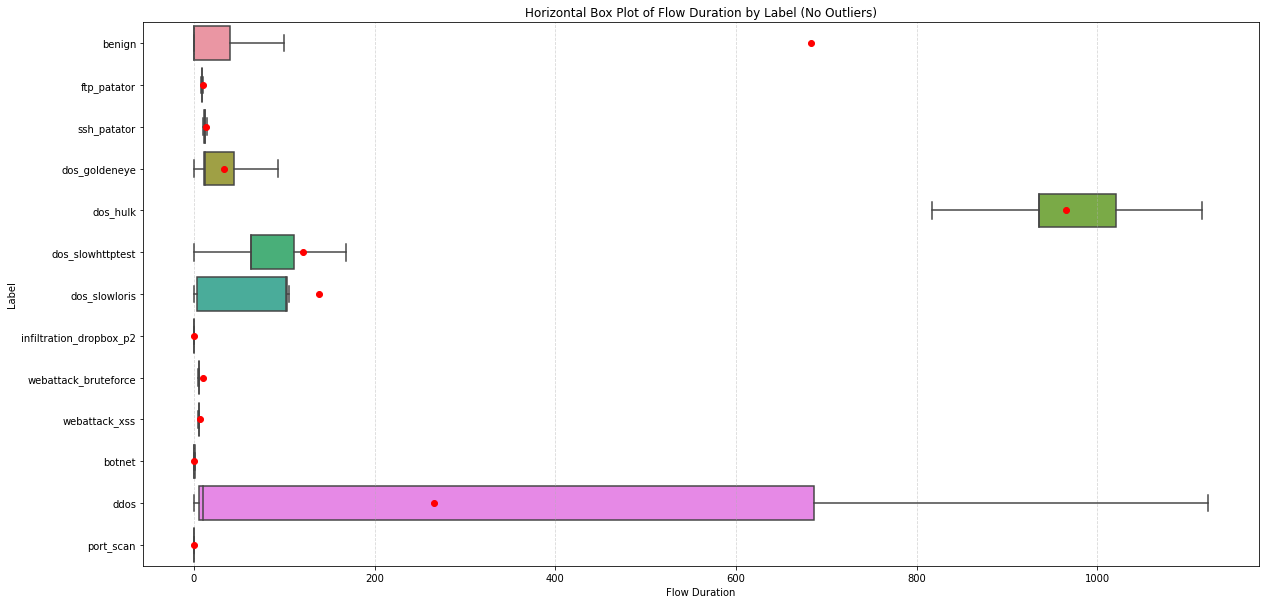

In [355]:
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='flow_duration', data=data, showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Flow Duration')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Flow Duration by Label (No Outliers)')

plt.show()

Analyzing flow duration distribution across attacks with small flow duration

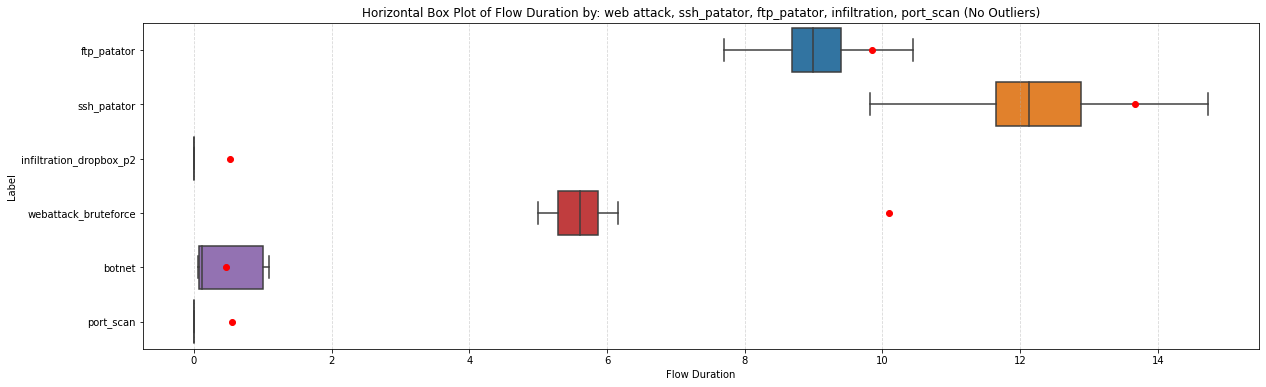

In [356]:
plt.figure(figsize=(20, 6))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='flow_duration', data=data[data['label'].isin(['webattack_bruteforce', 'ssh_patator', 'ftp_patator', 'infiltration_dropbox_p2',
                                                                        'port_scan', 'botnet'])],
            showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Flow Duration')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Flow Duration by: web attack, ssh_patator, ftp_patator, infiltration, port_scan (No Outliers)')

plt.show()

Log-Based

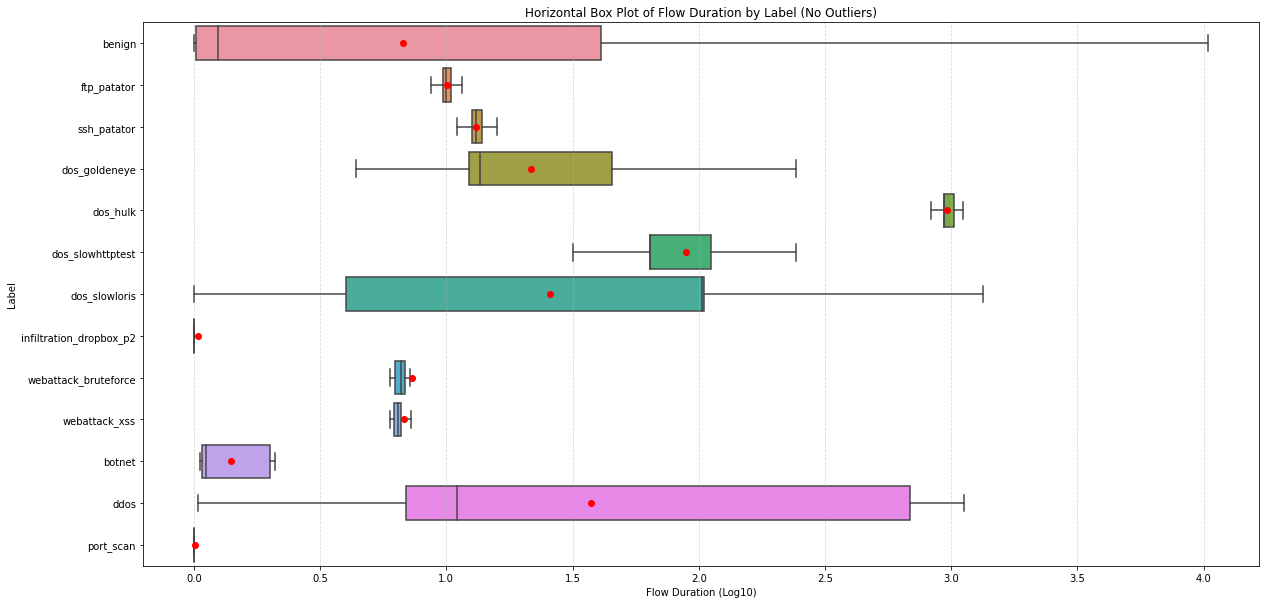

In [357]:
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='flow_duration_log', data=data, showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Flow Duration (Log10)')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Flow Duration by Label (No Outliers)')

plt.show()

Perform T-tests for all Pairs of Labels

In [358]:
labels = data['label'].unique()

In [359]:
grouped = data.groupby('label')['flow_duration']
results = []
for label1, label2 in combinations(labels, 2):
    group1 = grouped.get_group(label1)
    group2 = grouped.get_group(label2)
    t_stat, p_value = ttest_ind(group1, group2)
    results.append((label1, label2, t_stat, p_value))
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Label 1', 'Label 2', 'T-statistic', 'P-value'])

In [360]:
# Example: Bonferroni correction
adjusted_alpha = 0.05 / len(results_df)  # Adjusted significance threshold

# Filter significant results based on adjusted alpha
significant_results = results_df[results_df['P-value'] < adjusted_alpha]
non_significant_results = results_df[results_df['P-value'] >= adjusted_alpha]

In [361]:
non_significant_results

,Label 1,Label 2,T-statistic,P-value
18,ftp_patator,webattack_bruteforce,-0.198018,0.843039
28,ssh_patator,webattack_bruteforce,1.634120,0.102306
29,ssh_patator,webattack_xss,2.772891,0.005584
50,dos_slowhttptest,dos_slowloris,-3.367043,0.000763
65,infiltration_dropbox_p2,botnet,0.084962,0.932292
67,infiltration_dropbox_p2,port_scan,-0.362392,0.717059
68,webattack_bruteforce,webattack_xss,1.047477,0.295003
76,botnet,port_scan,-0.145058,0.884665


=> **Conclusion**: The statistical analysis using a t-test indicates that there is a significant difference in the distribution of flow durations between different attacks. This finding suggests that flow duration can serve as a meaningful indicator or predictor of attack events.

In the above table we can observe some exceptions: (dos_slowhttptest, dos_slowloris), (ssh_patator, web attack).

Both infiltration_dropbox_p2 and port_scan are not statistically different from each other, which is expected as infiltration_dropbox_p2 is essentially a port scan attack.

`total_packets`

In [362]:
data['total_packets'] = data['total_fwd_packets'] + data['total_bwd_packets']
data['total_packets_log'] = np.log10(data['total_packets']+1)

In [363]:
data['total_packets'].describe()

count    1.092506e+06
mean     3.795254e+01
std      5.489396e+03
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      1.800000e+01
max      2.458132e+06
Name: total_packets, dtype: float64

Analyzing total_packets distribution. Removing Heartbleed from analyzsis (only one sample)

In [364]:
list(set(data['label']))

['infiltration_dropbox_p2',
 'benign',
 'ssh_patator',
 'botnet',
 'dos_goldeneye',
 'dos_slowhttptest',
 'webattack_bruteforce',
 'dos_hulk',
 'ddos',
 'port_scan',
 'ftp_patator',
 'dos_slowloris',
 'webattack_xss']

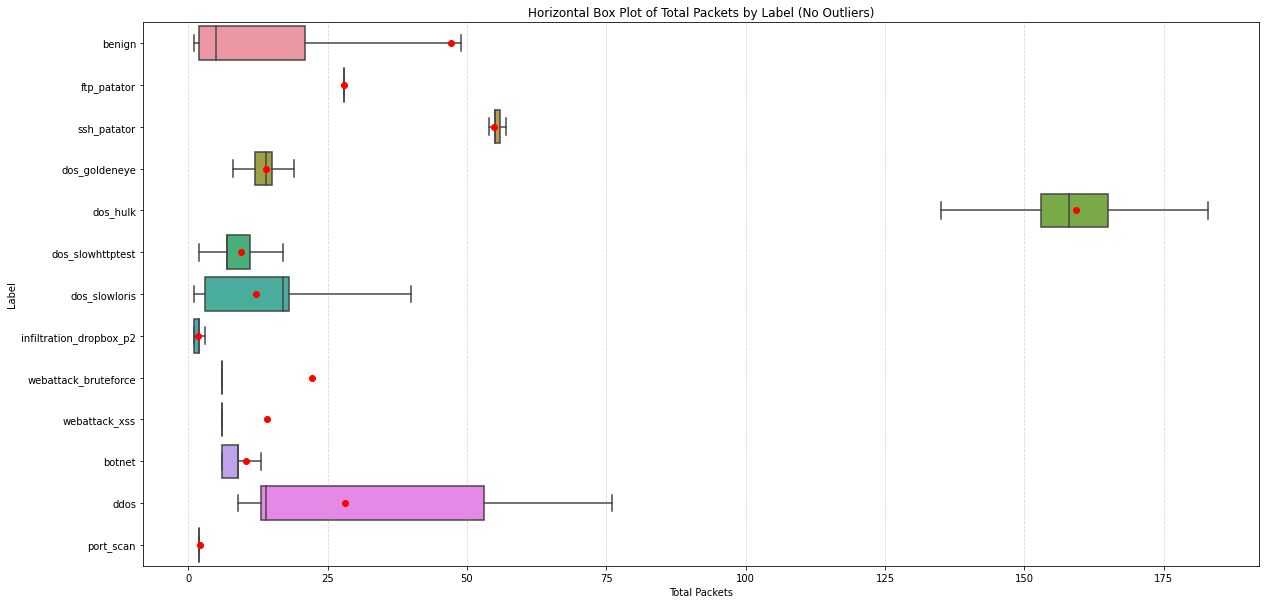

In [365]:
# col_analysis = ['dos_goldeneye', 'port_scan', 'botnet', 'ssh_patator', 'benign', 'dos_slowloris', 'ftp_patator', 'ddos', 'web attack',
#           'dos_slowhttptest', 'infiltration', 'dos_hulk']
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='total_packets', data=data, showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Total Packets')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Total Packets by Label (No Outliers)')

plt.show()

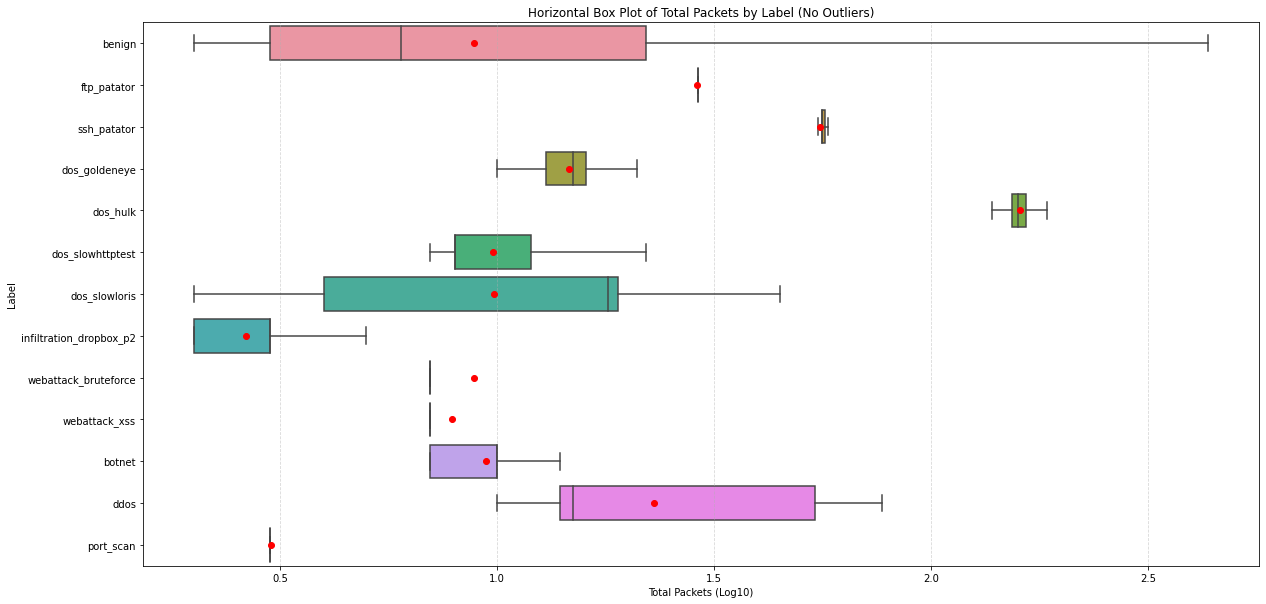

In [366]:
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='total_packets_log', data=data, showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Total Packets (Log10)')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Total Packets by Label (No Outliers)')

plt.show()

Perform T-tests for all Pairs of Labels

In [367]:
labels = data['label'].unique()

In [368]:
grouped = data.groupby('label')['total_packets']
results = []
for label1, label2 in combinations(labels, 2):
    group1 = grouped.get_group(label1)
    group2 = grouped.get_group(label2)
    t_stat, p_value = ttest_ind(group1, group2)
    results.append((label1, label2, t_stat, p_value))
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Label 1', 'Label 2', 'T-statistic', 'P-value'])

In [369]:
# Example: Bonferroni correction
adjusted_alpha = 0.05 / len(results_df)  # Adjusted significance threshold

# Filter significant results based on adjusted alpha
significant_results = results_df[results_df['P-value'] < adjusted_alpha]
non_significant_results = results_df[results_df['P-value'] >= adjusted_alpha]

In [370]:
non_significant_results

,Label 1,Label 2,T-statistic,P-value
0,benign,ftp_patator,0.187519,0.851253
1,benign,ssh_patator,-0.064295,0.948735
2,benign,dos_goldeneye,0.445360,0.656060
3,benign,dos_hulk,-2.054056,0.039971
4,benign,dos_slowhttptest,0.378528,0.705039
5,benign,dos_slowloris,0.336694,0.736348
6,benign,infiltration_dropbox_p2,1.762882,0.077921
7,benign,webattack_bruteforce,0.142583,0.886619
8,benign,webattack_xss,0.132640,0.894478
9,benign,botnet,0.198462,0.842683


=> **Conclusion**: 
- Benign Traffic vs. Attacks:

The distribution of 'total_packets' does not exhibit statistically significant differences between benign traffic and the aggregate of all attack types. This suggests that 'total_packets' alone may not reliably differentiate benign traffic from attacks.

=> Infiltration and Port-Scan are different !

- Differentiation Among Attack Types:

However, 'total_packets' demonstrates statistically significant differences among specific attack types, including DDoS, dos_goldeneye, dos_hulk, dos_slowhttptest, and dos_slowloris. Therefore, 'total_packets' serves as a useful feature for distinguishing between these specific types of attacks.

- `inter_arrival_mean`

In [371]:
data['inter_arrival_mean'].describe()

count    1.060019e+06
mean     9.720333e+01
std      5.817082e+02
min     -1.300000e-05
25%      1.680000e-04
50%      3.186100e-02
75%      1.030839e+00
max      9.537357e+03
Name: inter_arrival_mean, dtype: float64

In [372]:
# inter_arrival_mean must be null ONLT if the total packets is == 1 

assert data[data['inter_arrival_mean'].isnull() & data['total_packets'] > 1].shape[0] == 0

In [373]:
data['inter_arrival_mean_modified'] = data['inter_arrival_mean'].fillna(0)

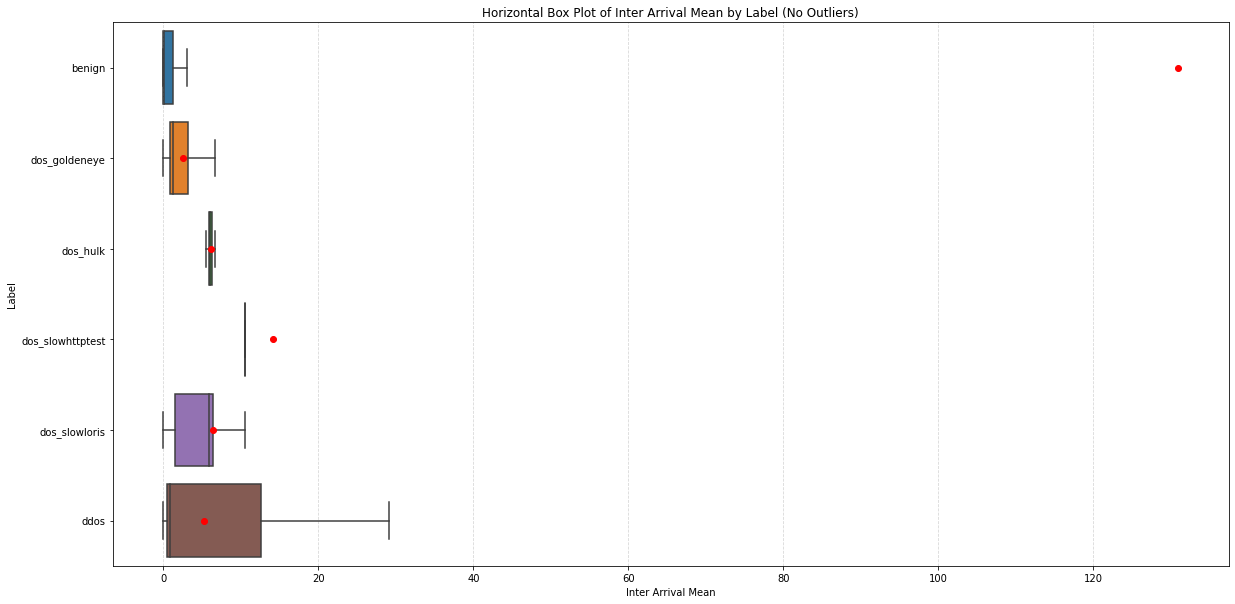

In [374]:
col_analysis_1 = ['benign', 'ddos','dos_slowloris','dos_slowhttptest', 'dos_hulk', 'dos_goldeneye']
# col_analysis = data['label'].unique()
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='inter_arrival_mean_modified', data=data[data['label'].isin(col_analysis_1)], showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Inter Arrival Mean')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Inter Arrival Mean by Label (No Outliers)')

plt.show()

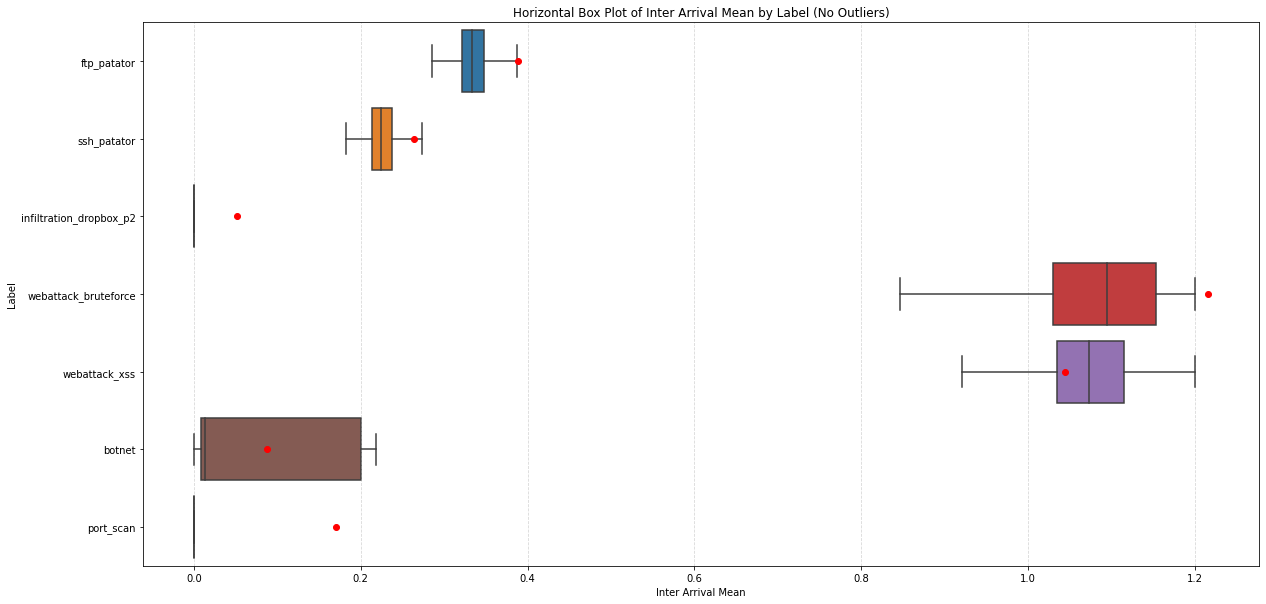

In [375]:
col_analysis_2 = set(data['label'].unique()) - set(col_analysis_1)#['web attack', 'ssh_patator', 'port_scan', 'heartbleed', 'ftp_patator', 'botnet']
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='inter_arrival_mean_modified', data=data[data['label'].isin(col_analysis_2)], showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Inter Arrival Mean')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Inter Arrival Mean by Label (No Outliers)')

plt.show()

Perform T-tests for all Pairs of Labels

In [376]:
labels = data['label'].unique()

In [377]:
grouped = data.groupby('label')['inter_arrival_mean_modified']
results = []
for label1, label2 in combinations(labels, 2):
    group1 = grouped.get_group(label1)
    group2 = grouped.get_group(label2)
    t_stat, p_value = ttest_ind(group1, group2)
    results.append((label1, label2, t_stat, p_value))
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Label 1', 'Label 2', 'T-statistic', 'P-value'])

In [378]:
# Example: Bonferroni correction
adjusted_alpha = 0.05 / len(results_df)  # Adjusted significance threshold

# Filter significant results based on adjusted alpha
significant_results = results_df[results_df['P-value'] < adjusted_alpha]
non_significant_results = results_df[results_df['P-value'] >= adjusted_alpha]

In [379]:
non_significant_results

,Label 1,Label 2,T-statistic,P-value
22,ftp_patator,port_scan,2.159555,0.030809
32,ssh_patator,port_scan,0.802147,0.422469
43,dos_hulk,dos_slowloris,-3.121360,0.001803
65,infiltration_dropbox_p2,botnet,-0.962025,0.336041
68,webattack_bruteforce,webattack_xss,0.872552,0.383010
76,botnet,port_scan,-0.450693,0.652211


=> **Conclusion**: 


- Differentiation Between Attacks and Non-Attacks:

Inter-arrival time demonstrates statistically significant differences between attacks and non-attacks. This suggests that inter-arrival time is a valuable indicator for distinguishing malicious traffic from benign traffic.

=> Port Scan and Infiltration_drop_p2 have differetn distributions!

- Differentiation Among Attack Types:

Inter-arrival time also shows statistically significant differences among most attack types. However, the result is not statistically significant for the 'heartbleed' attack. This exception is disregarded due to the limited sample size (only 1 sample for 'heartbleed').


`total_fwd_packets` & `total_bwd_packets` 

In [380]:
assert data['total_fwd_packets'].isnull().sum() == 0

In [381]:
data['total_fwd_packets_log'] = np.log1p(data['total_fwd_packets'])
data['total_bwd_packets_log'] = np.log1p(data['total_bwd_packets'])

In [382]:
data[(data['label'] == 'infiltration_dropbox_p2') & (data['total_fwd_packets'] < data['total_bwd_packets'] )][['total_fwd_packets', 'total_bwd_packets']].shape[0]/data[(data['label'] == 'infiltration_dropbox_p2')].shape[0]

0.04401305725955246

In [383]:
data[(data['label'] == 'port_scan')][['total_bwd_packets', 'total_fwd_packets']].describe()

,total_bwd_packets,total_fwd_packets
count,160003.000000,160003.000000
mean,1.006462,1.019287
std,0.170976,0.339229
min,0.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,36.000000,98.000000


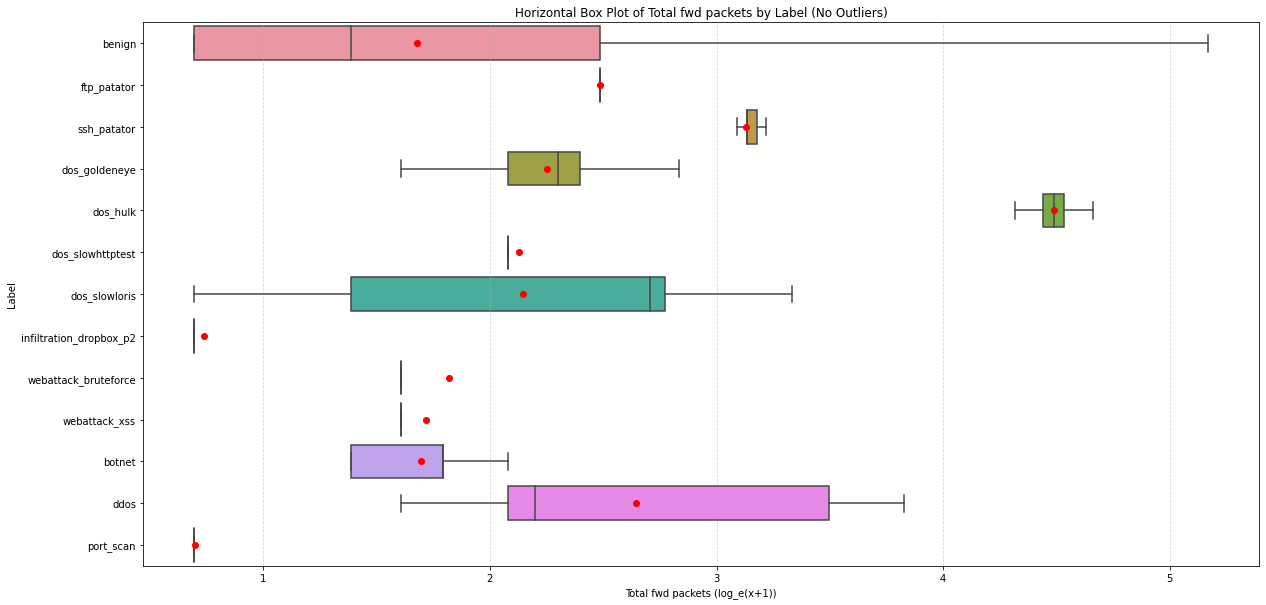

In [384]:
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='total_fwd_packets_log', data=data, showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Total fwd packets (log_e(x+1))')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Total fwd packets by Label (No Outliers)')

plt.show()

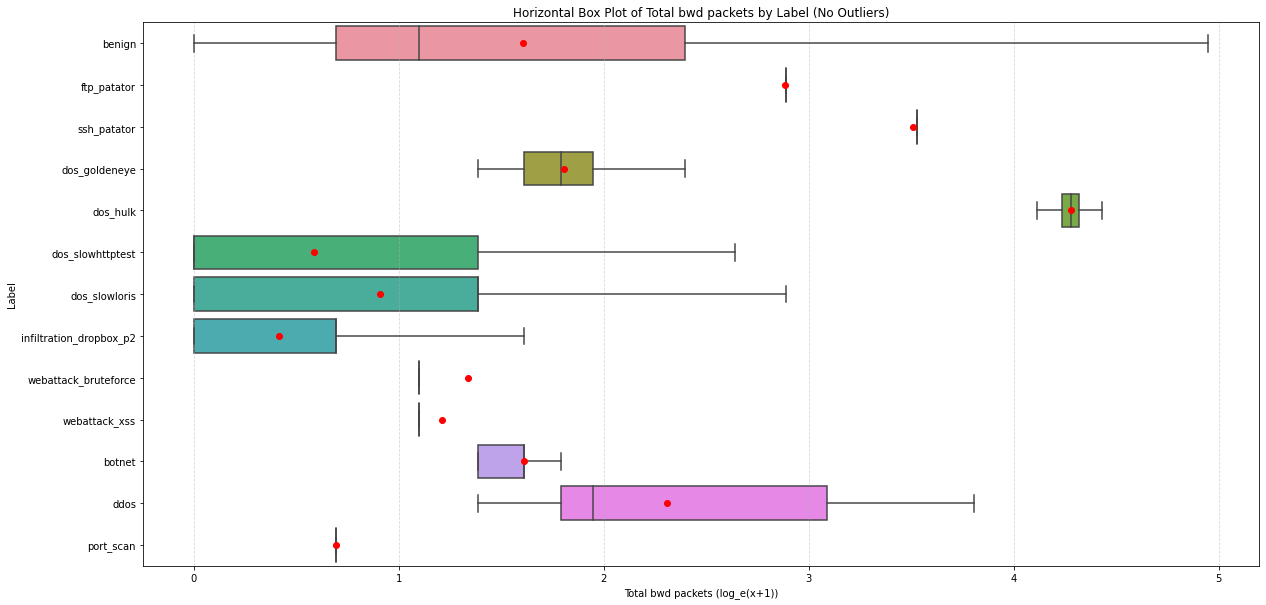

In [385]:
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='total_bwd_packets_log', data=data, showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Total bwd packets (log_e(x+1))')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Total bwd packets by Label (No Outliers)')

plt.show()

Perform T-tests for all Pairs of Labels

In [386]:
labels = data['label'].unique()

In [387]:
grouped = data.groupby('label')['total_fwd_packets']
results = []
for label1, label2 in combinations(labels, 2):
    group1 = grouped.get_group(label1)
    group2 = grouped.get_group(label2)
    t_stat, p_value = ttest_ind(group1, group2)
    results.append((label1, label2, t_stat, p_value))
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Label 1', 'Label 2', 'T-statistic', 'P-value'])

In [388]:
# Example: Bonferroni correction
adjusted_alpha = 0.05 / len(results_df)  # Adjusted significance threshold

# Filter significant results based on adjusted alpha
significant_results = results_df[results_df['P-value'] < adjusted_alpha]
non_significant_results = results_df[results_df['P-value'] >= adjusted_alpha]

In [389]:
non_significant_results

,Label 1,Label 2,T-statistic,P-value
0,benign,ftp_patator,0.234799,0.814365
1,benign,ssh_patator,-0.014368,0.988536
2,benign,dos_goldeneye,0.392617,0.694602
3,benign,dos_hulk,-2.860620,0.004228
4,benign,dos_slowhttptest,0.318033,0.750460
5,benign,dos_slowloris,0.264641,0.791286
6,benign,infiltration_dropbox_p2,1.832450,0.066885
7,benign,webattack_bruteforce,0.090105,0.928203
8,benign,webattack_xss,0.112309,0.910578
9,benign,botnet,0.204731,0.837782


In [390]:
grouped = data.groupby('label')['total_bwd_packets']
results = []
for label1, label2 in combinations(labels, 2):
    group1 = grouped.get_group(label1)
    group2 = grouped.get_group(label2)
    t_stat, p_value = ttest_ind(group1, group2)
    results.append((label1, label2, t_stat, p_value))
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Label 1', 'Label 2', 'T-statistic', 'P-value'])

In [391]:
# Example: Bonferroni correction
adjusted_alpha = 0.05 / len(results_df)  # Adjusted significance threshold

# Filter significant results based on adjusted alpha
significant_results = results_df[results_df['P-value'] < adjusted_alpha]
non_significant_results = results_df[results_df['P-value'] >= adjusted_alpha]

In [392]:
non_significant_results

,Label 1,Label 2,T-statistic,P-value
0,benign,ftp_patator,0.152124,0.879089
1,benign,ssh_patator,-0.101635,0.919046
2,benign,dos_goldeneye,0.484752,0.627853
3,benign,dos_hulk,-1.450390,0.146950
4,benign,dos_slowhttptest,0.423728,0.671764
5,benign,dos_slowloris,0.390547,0.696132
6,benign,infiltration_dropbox_p2,1.710588,0.087158
7,benign,webattack_bruteforce,0.181820,0.855724
8,benign,webattack_xss,0.147830,0.882477
9,benign,botnet,0.193745,0.846376


=> Conclusion:

Doesn't help in destinguishing between benign and attacks; 
For instance, It helps differentiate infiltration_dropbox_p2 and portscan; DDoS; it struggles to differentiate webattack_xss incidents.

`avg_bwd_pkt_size`

In [475]:
assert data['avg_bwd_pkt_size'].isnull().sum() != 0

In [476]:
# data['total_fwd_packets_log'] = np.log1p(data['total_fwd_packets'])
# data['total_bwd_packets_log'] = np.log1p(data['total_bwd_packets'])

In [477]:
# data[(data['label'] == 'infiltration_dropbox_p2') & (data['total_fwd_packets'] < data['total_bwd_packets'] )][['total_fwd_packets', 'total_bwd_packets']].shape[0]/data[(data['label'] == 'infiltration_dropbox_p2')].shape[0]

In [480]:
data[(data['label'] == 'botnet')][['total_bwd_pkt_size']].describe()

,total_bwd_pkt_size
count,1226.000000
mean,298.321370
std,399.509969
min,120.000000
25%,120.000000
50%,300.000000
75%,300.000000
max,3580.000000


In [400]:
data[(data['label'] == 'ddos')][['avg_bwd_pkt_size']].describe()

,avg_bwd_pkt_size
count,45480.000000
mean,2224.174304
std,418.671294
min,43.200000
25%,1974.500000
50%,2212.864000
75%,2361.400000
max,3909.000000


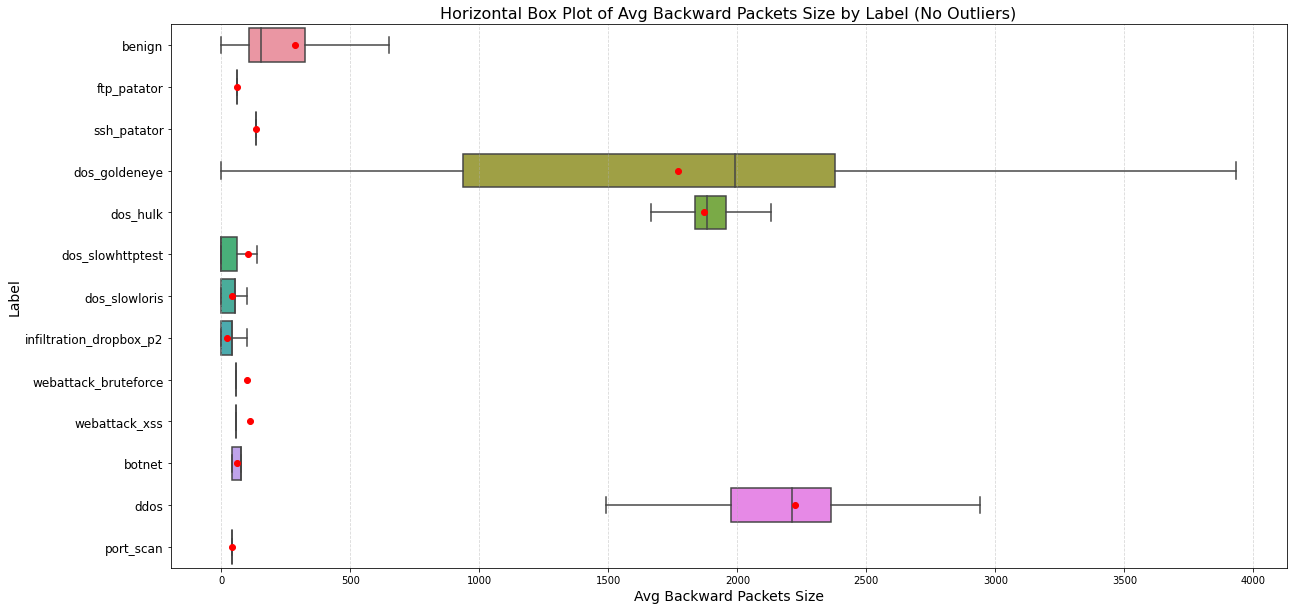

In [434]:
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='avg_bwd_pkt_size', data=data.fillna(0), showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Set y-axis tick labels font size
plt.yticks(fontsize=12)  # Adjust fontsize as needed

# Add labels and title
plt.xlabel('Avg Backward Packets Size', fontsize=14)  # Adjust fontsize for x-axis label
plt.ylabel('Label', fontsize=14)  # Adjust fontsize for y-axis label
plt.title('Horizontal Box Plot of Avg Backward Packets Size by Label (No Outliers)', fontsize=16)  # Adjust title fontsize

plt.show()

Perform T-tests for all Pairs of Labels

In [411]:
labels = data['label'].unique()

In [417]:
labels

array(['benign', 'ftp_patator', 'ssh_patator', 'dos_goldeneye',
       'dos_hulk', 'dos_slowhttptest', 'dos_slowloris',
       'infiltration_dropbox_p2', 'webattack_bruteforce', 'webattack_xss',
       'botnet', 'ddos', 'port_scan'], dtype=object)

In [427]:
grouped = data.fillna(0).groupby('label')['avg_bwd_pkt_size']
results = []
for label1, label2 in combinations(labels, 2):
    group1 = grouped.get_group(label1)
    group2 = grouped.get_group(label2)
    t_stat, p_value = ttest_ind(group1, group2)
    results.append((label1, label2, t_stat, p_value))
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Label 1', 'Label 2', 'T-statistic', 'P-value'])

In [428]:
# Example: Bonferroni correction
adjusted_alpha = 0.05 / len(results_df)  # Adjusted significance threshold

# Filter significant results based on adjusted alpha
significant_results = results_df[results_df['P-value'] < adjusted_alpha]
non_significant_results = results_df[results_df['P-value'] >= adjusted_alpha]

In [433]:
significant_results[(significant_results['Label 1'] == 'ddos') | (significant_results['Label 2'] == 'ddos')]

,Label 1,Label 2,T-statistic,P-value
10,benign,ddos,-1195.329165,0.0
21,ftp_patator,ddos,-326.314484,0.0
31,ssh_patator,ddos,-272.270807,0.0
40,dos_goldeneye,ddos,-77.821601,0.0
48,dos_hulk,ddos,-96.369821,0.0
55,dos_slowhttptest,ddos,-326.082930,0.0
61,dos_slowloris,ddos,-325.223594,0.0
66,infiltration_dropbox_p2,ddos,-1314.103624,0.0
70,webattack_bruteforce,ddos,-187.049413,0.0
73,webattack_xss,ddos,-131.052819,0.0


`total_bwd_pkt_size`

In [443]:
assert data['total_bwd_pkt_size'].isnull().sum() == 0

In [444]:
# data['total_fwd_packets_log'] = np.log1p(data['total_fwd_packets'])
# data['total_bwd_packets_log'] = np.log1p(data['total_bwd_packets'])

In [445]:
# data[(data['label'] == 'infiltration_dropbox_p2') & (data['total_fwd_packets'] < data['total_bwd_packets'] )][['total_fwd_packets', 'total_bwd_packets']].shape[0]/data[(data['label'] == 'infiltration_dropbox_p2')].shape[0]

In [446]:
data[(data['label'] == 'infiltration_dropbox_p2')][['total_bwd_pkt_size']].describe()

,total_bwd_pkt_size
count,63413.000000
mean,39.675729
std,467.538597
min,0.000000
25%,0.000000
50%,40.000000
75%,40.000000
max,23762.000000


In [447]:
data[(data['label'] == 'port_scan')][['total_bwd_pkt_size']].describe()

,total_bwd_pkt_size
count,160003.000000
mean,46.760429
std,272.836952
min,0.000000
25%,40.000000
50%,40.000000
75%,40.000000
max,11975.000000


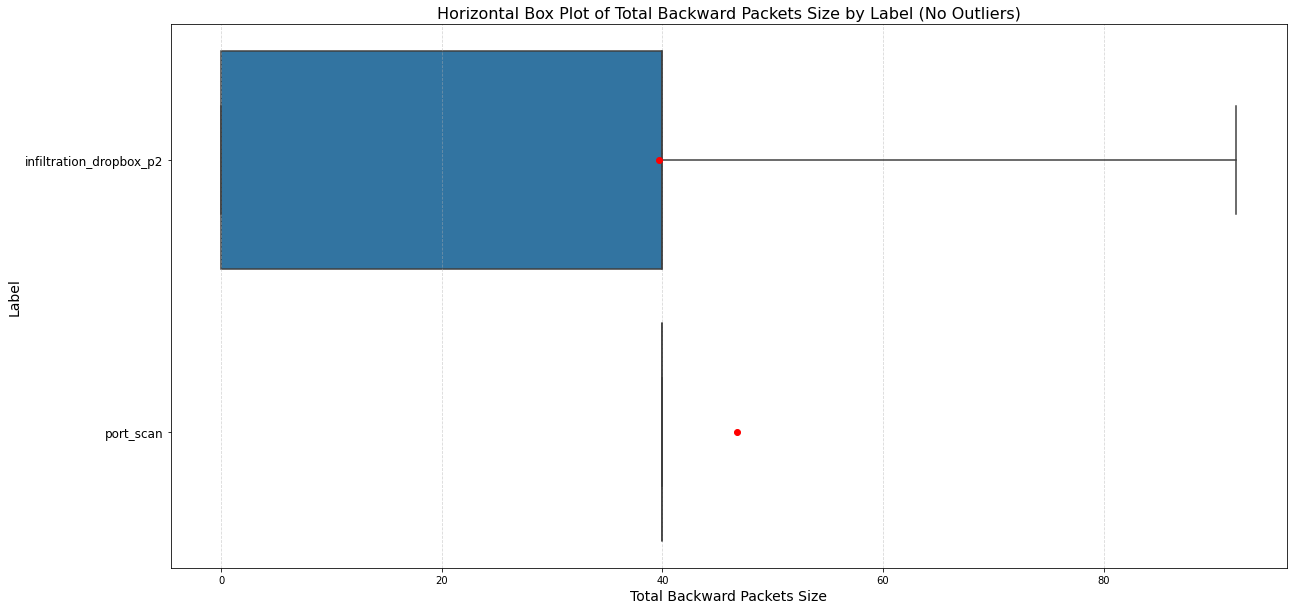

In [455]:
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='total_bwd_pkt_size', data=data[data['label'].isin(['port_scan', 'infiltration_dropbox_p2'])].fillna(0), showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Set y-axis tick labels font size
plt.yticks(fontsize=12)  # Adjust fontsize as needed

# Add labels and title
plt.xlabel('Total Backward Packets Size', fontsize=14)  # Adjust fontsize for x-axis label
plt.ylabel('Label', fontsize=14)  # Adjust fontsize for y-axis label
plt.title('Horizontal Box Plot of Total Backward Packets Size by Label (No Outliers)', fontsize=16)  # Adjust title fontsize

plt.show()

`fwd_flow_duration`

In [457]:
assert data['fwd_flow_duration'].isnull().sum() == 0

In [458]:
# data['total_fwd_packets_log'] = np.log1p(data['total_fwd_packets'])
# data['total_bwd_packets_log'] = np.log1p(data['total_bwd_packets'])

In [459]:
# data[(data['label'] == 'infiltration_dropbox_p2') & (data['total_fwd_packets'] < data['total_bwd_packets'] )][['total_fwd_packets', 'total_bwd_packets']].shape[0]/data[(data['label'] == 'infiltration_dropbox_p2')].shape[0]

In [460]:
data[(data['label'] == 'infiltration_dropbox_p2')][['fwd_flow_duration']].describe()

,fwd_flow_duration
count,63413.000000
mean,0.360656
std,23.220729
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2241.231720


In [461]:
data[(data['label'] == 'port_scan')][['fwd_flow_duration']].describe()

,fwd_flow_duration
count,160003.000000
mean,0.560279
std,23.197949
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,3415.672601


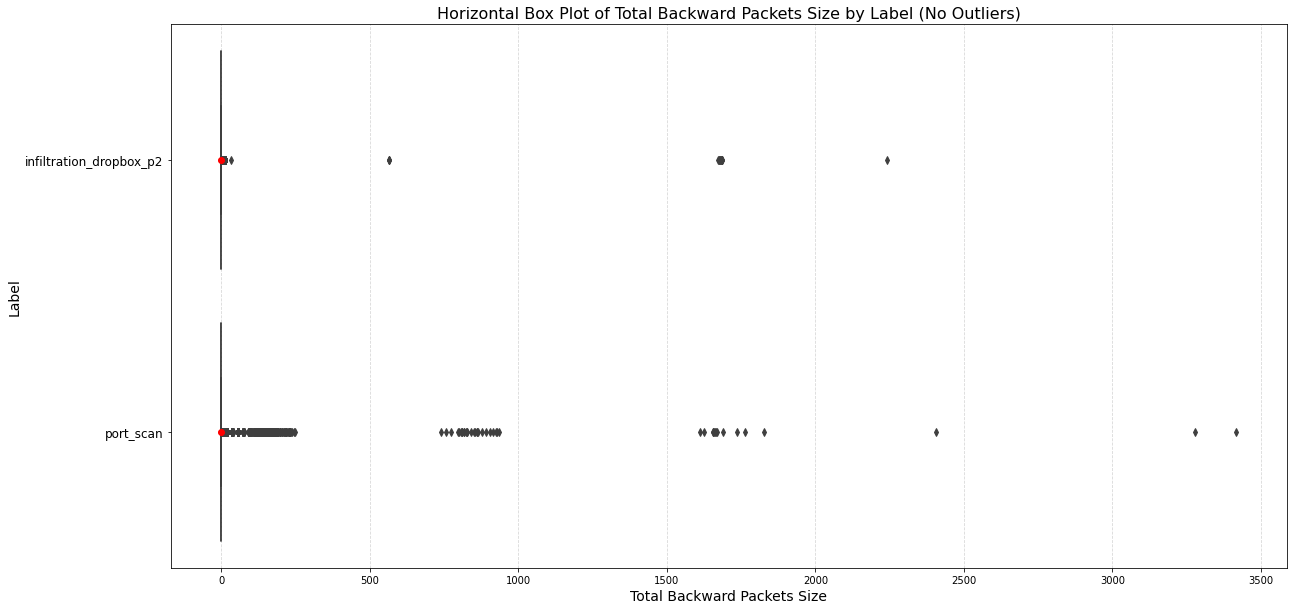

In [463]:
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='fwd_flow_duration', data=data[data['label'].isin(['port_scan', 'infiltration_dropbox_p2'])].fillna(0), showfliers=True, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Set y-axis tick labels font size
plt.yticks(fontsize=12)  # Adjust fontsize as needed

# Add labels and title
plt.xlabel('Total Backward Packets Size', fontsize=14)  # Adjust fontsize for x-axis label
plt.ylabel('Label', fontsize=14)  # Adjust fontsize for y-axis label
plt.title('Horizontal Box Plot of Total Backward Packets Size by Label (No Outliers)', fontsize=16)  # Adjust title fontsize

plt.show()

**Analyzing: Flow Observation Duration**

In [329]:
data['first_timestamp_dt'] = pd.to_datetime(data['first_timestamp'])
data['last_timestamp_dt'] = pd.to_datetime(data['last_timestamp'])

In [330]:
data['diff_in_seconds'] = (data['last_timestamp_dt'] - data['first_timestamp_dt']).dt.total_seconds()

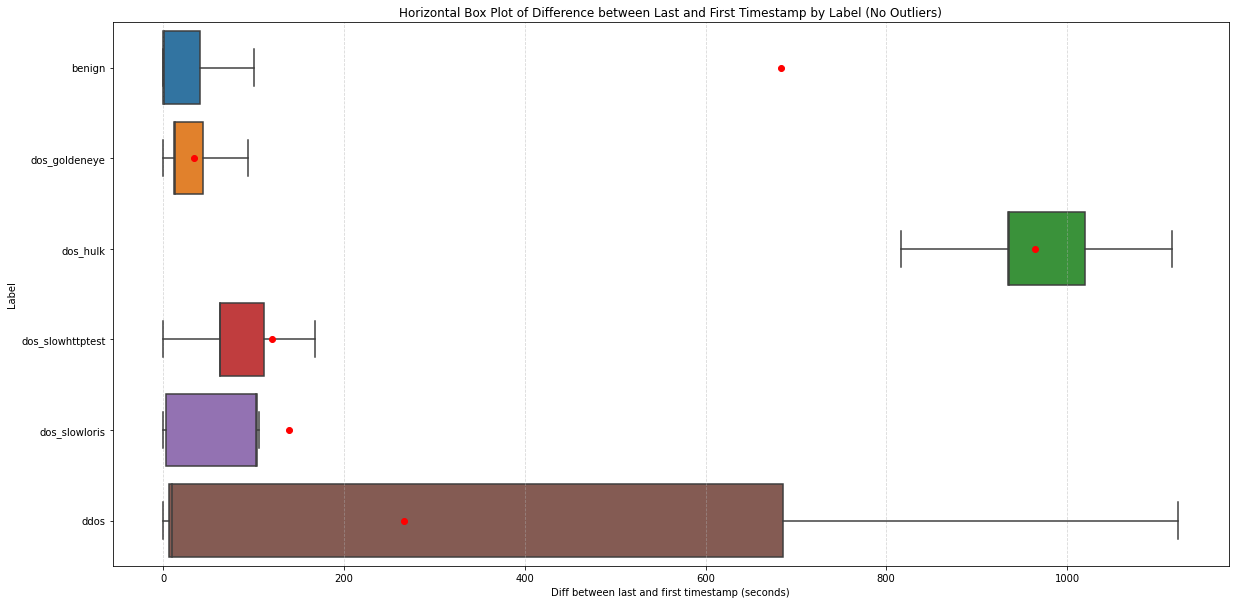

In [331]:
col_analysis_1 = ['benign', 'ddos','dos_slowloris','dos_slowhttptest', 'dos_hulk', 'dos_goldeneye']

plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='diff_in_seconds', data=data[data['label'].isin(col_analysis_1)], showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Diff between last and first timestamp (seconds)')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Difference between Last and First Timestamp by Label (No Outliers)')

plt.show()

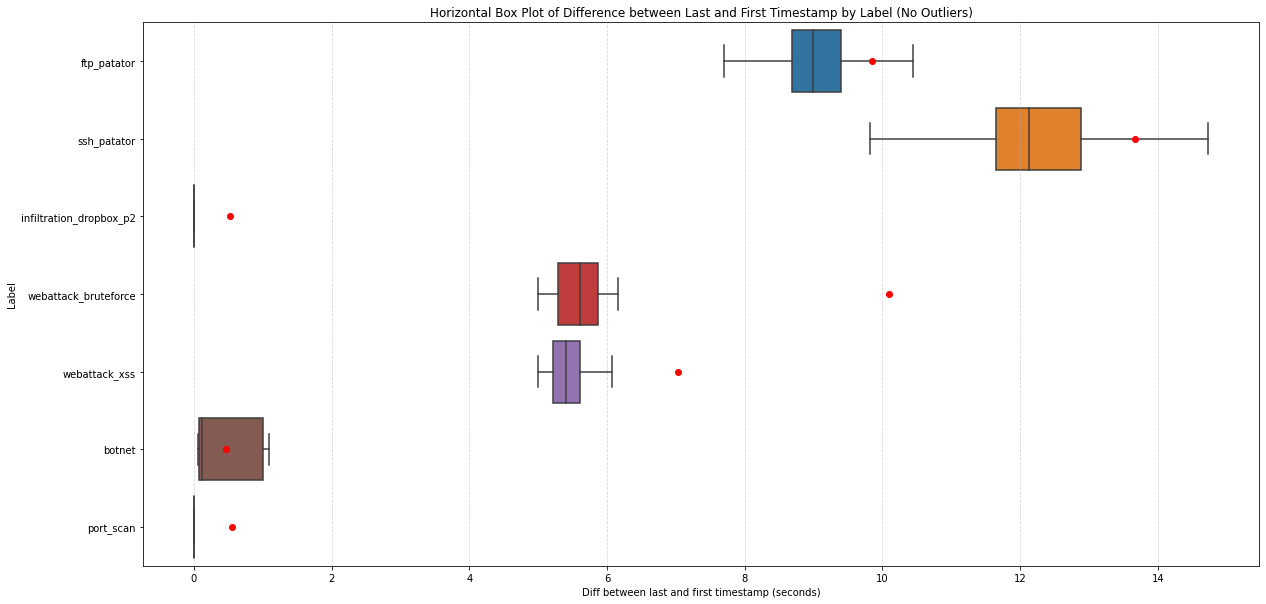

In [332]:
col_analysis_2 = set(data['label']) - set(col_analysis_1)

plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='diff_in_seconds', data=data[data['label'].isin(col_analysis_2)], showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Diff between last and first timestamp (seconds)')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Difference between Last and First Timestamp by Label (No Outliers)')

plt.show()

In [333]:
data['diff_in_seconds'].describe()

count    1.092506e+06
mean     5.148961e+02
std      2.608950e+03
min      0.000000e+00
25%      1.560000e-04
50%      8.968800e-02
75%      1.110656e+01
max      2.904384e+04
Name: diff_in_seconds, dtype: float64

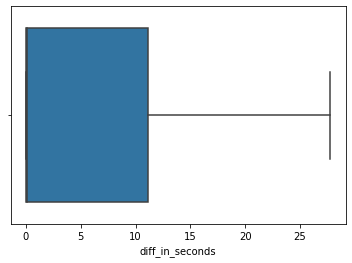

In [334]:
sns.boxplot(x=data['diff_in_seconds'],  showfliers=False);

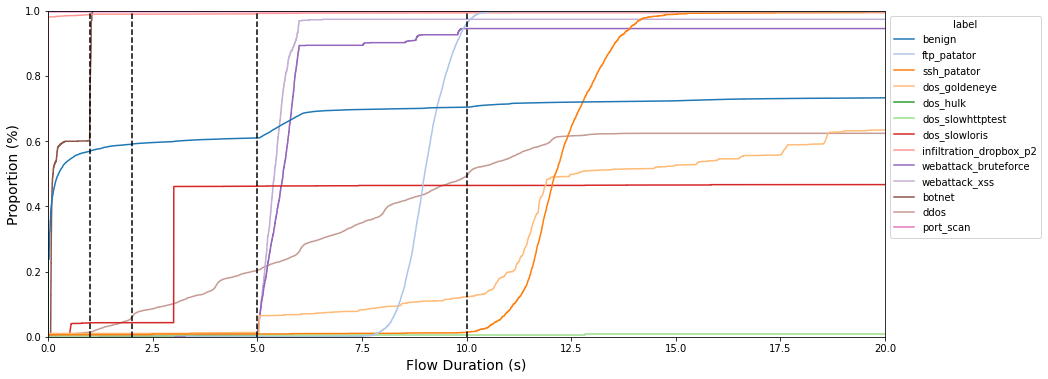

In [337]:
pair = sns.color_palette("tab20")

ax = sns.ecdfplot(data=data, x="diff_in_seconds", hue='label', palette=pair[:len(set(data['label']))])

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.gcf().set_size_inches(15, 6)  # Set figure size (width, height)
plt.xlim(0, 20)  # Adjust the x-axis limits here

# Draw vertical lines at specific x-values (1, 2, 5, and 10)
obs_intervals = [1, 2, 5, 10]
for line_value in obs_intervals:
    plt.axvline(x=line_value, color='black', linestyle='--', linewidth=1.5)

plt.xlabel('Flow Duration (s)', fontsize=14)
plt.ylabel('Proportion (%)', fontsize=14)  # Adjust fontsize as needed

plt.show()

In [62]:
obs_intervals = [1, 2, 5, 10]
unique_labels = set(data['label'])
for i in obs_intervals:
    print(f'===========Obs Interval: {i}===========')
    for label in unique_labels:
        tmp = data[data['label'] == label]
        pct = (tmp[tmp['diff_in_seconds'] < i]).shape[0]*100/tmp.shape[0]
        print(f'{label}: {pct:.2f}%')

===========Obs Interval: 1===========
infiltration_dropbox_p2: 98.85%
benign: 56.93%
ssh_patator: 0.64%
botnet: 71.45%
dos_goldeneye: 1.03%
dos_slowhttptest: 0.21%
webattack_bruteforce: 0.00%
dos_hulk: 0.00%
ddos: 1.48%
port_scan: 99.68%
ftp_patator: 0.00%
dos_slowloris: 4.31%
webattack_xss: 0.29%
===========Obs Interval: 2===========
infiltration_dropbox_p2: 98.93%
benign: 59.07%
ssh_patator: 0.64%
botnet: 100.00%
dos_goldeneye: 1.03%
dos_slowhttptest: 0.24%
webattack_bruteforce: 0.15%
dos_hulk: 0.00%
ddos: 6.00%
port_scan: 99.68%
ftp_patator: 0.00%
dos_slowloris: 4.31%
webattack_xss: 0.29%
===========Obs Interval: 5===========
infiltration_dropbox_p2: 98.97%
benign: 60.97%
ssh_patator: 0.84%
botnet: 100.00%
dos_goldeneye: 1.31%
dos_slowhttptest: 0.57%
webattack_bruteforce: 0.59%
dos_hulk: 0.00%
ddos: 20.36%
port_scan: 99.68%
ftp_patator: 0.03%
dos_slowloris: 46.16%
webattack_xss: 1.18%
===========Obs Interval: 10===========
infiltration_dropbox_p2: 99.29%
benign: 70.41%
ssh_patator: 

In [354]:
obs_intervals = [1, 2, 5, 10]
unique_labels = set(data['label'])
for i in obs_intervals:
    print(f'===========Obs Interval: {i}===========')
    for label in unique_labels:
        tmp = data[data['label'] == label]
        pct = (tmp[tmp['diff_in_seconds'] < i]).shape[0]*100/tmp.shape[0]
        print(f'{label}: {pct:.2f}%')

===========Obs Interval: 1===========
dos_hulk: 0.00%
dos_slowhttptest: 0.21%
dos_slowloris: 4.31%
botnet: 71.45%
ddos: 1.48%
webattack_bruteforce: 0.00%
benign: 56.93%
ftp_patator: 0.00%
port_scan: 99.68%
infiltration_dropbox_p2: 98.85%
dos_goldeneye: 1.03%
webattack_xss: 0.29%
ssh_patator: 0.64%
===========Obs Interval: 2===========
dos_hulk: 0.00%
dos_slowhttptest: 0.24%
dos_slowloris: 4.31%
botnet: 100.00%
ddos: 6.00%
webattack_bruteforce: 0.15%
benign: 59.07%
ftp_patator: 0.00%
port_scan: 99.68%
infiltration_dropbox_p2: 98.93%
dos_goldeneye: 1.03%
webattack_xss: 0.29%
ssh_patator: 0.64%
===========Obs Interval: 5===========
dos_hulk: 0.00%
dos_slowhttptest: 0.57%
dos_slowloris: 46.16%
botnet: 100.00%
ddos: 20.36%
webattack_bruteforce: 0.59%
benign: 60.97%
ftp_patator: 0.03%
port_scan: 99.68%
infiltration_dropbox_p2: 98.97%
dos_goldeneye: 1.31%
webattack_xss: 1.18%
ssh_patator: 0.84%
===========Obs Interval: 10===========
dos_hulk: 0.00%
dos_slowhttptest: 0.69%
dos_slowloris: 46.39

# Model

In [138]:
# features = ['flow_duration', 'inter_arrival_mean_modified',
#             'total_packets', 'total_fwd_packets', 'total_bwd_packets',
#             'total_size', 'std_size'] # new ones

features = ['avg_size', 'std_size', 'total_size', 
       'inter_arrival_mean', 'inter_arrival_std', 'total_fwd_packets',
       'fwd_flow_duration',
       'total_fwd_pkt_size', 'avg_fwd_pkt_size', 'std_fwd_pkt_size',
       'inter_arrival_mean_fwd', 'inter_arrival_std_fwd', 'total_bwd_packets', 'bwd_flow_duration',
       'total_bwd_pkt_size', 'avg_bwd_pkt_size', 'std_bwd_pkt_size',
       'inter_arrival_mean_bwd', 'inter_arrival_std_bwd','total_packets']

label = ['label']

In [216]:
from tabulate import tabulate

In [228]:
# Calculate value counts of the label column
value_counts = data[label].value_counts()

# Convert value counts to a DataFrame for easier formatting
value_counts_df = pd.DataFrame(value_counts).reset_index()
value_counts_df.columns = ['Label', 'Count']

# Calculate percentage of each class relative to the total number of samples
total_samples = len(data[label])
value_counts_df['Percentage'] = (value_counts_df['Count'] / total_samples) * 100
value_counts_df['Percentage'] = value_counts_df['Percentage'].round(2)

# Sort DataFrame by label (optional, if you want to sort by label)
value_counts_df = value_counts_df.sort_values(by='Label')

# Add a row for the total count and percentage
total_count = value_counts_df['Count'].sum()
total_percentage = round((total_count / total_samples) * 100,2)

total_row = pd.DataFrame({'Label': 'Total', 'Count': total_count, 'Percentage': total_percentage}, index=[0])
value_counts_df = pd.concat([value_counts_df, total_row], ignore_index=True)

# Convert DataFrame to a pretty table using tabulate
table = tabulate(value_counts_df, headers='keys', tablefmt='psql', showindex=False)

# Print the pretty table
print(table)

+-------------------------+---------+--------------+
| Label                   |   Count |   Percentage |
|-------------------------+---------+--------------|
| benign                  |  783574 |        71.72 |
| botnet                  |    1226 |         0.11 |
| ddos                    |   45480 |         4.16 |
| dos_goldeneye           |    7574 |         0.69 |
| dos_hulk                |   14108 |         1.29 |
| dos_slowhttptest        |    4217 |         0.39 |
| dos_slowloris           |    3895 |         0.36 |
| ftp_patator             |    3993 |         0.37 |
| infiltration_dropbox_p2 |   63413 |         5.8  |
| port_scan               |  160003 |        14.65 |
| ssh_patator             |    2979 |         0.27 |
| webattack_bruteforce    |    1365 |         0.12 |
| webattack_xss           |     679 |         0.06 |
| Total                   | 1092506 |       100    |
+-------------------------+---------+--------------+


In [227]:
total_percentage

100.0

In [139]:
# Training sampling the dataset
# Count 'benign' rows
benign_rows = data[data['label'] == 'benign']
num_benign = len(benign_rows)

# Calculate number of 'benign' rows to keep (50% reduction)
num_benign_to_keep = int(num_benign * 0.5)

# Randomly select rows to keep
selected_benign_rows = benign_rows.sample(n=num_benign_to_keep, random_state=42)

# Select rows with labels other than 'benign'
non_benign_rows = data[data['label'] != 'benign']

# Combine selected 'benign' rows with non-'benign' rows
downsampled_df = pd.concat([selected_benign_rows, non_benign_rows])

In [140]:
# # data_filt = data[data['label'] != 'benign']
# data['']

X_down = downsampled_df[features]
y_down = downsampled_df[label]

X = X_down.copy()
y = y_down.copy()

# X = data[features]
# y = data[label]

le = LabelEncoder()
y_encoded = le.fit_transform(y)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

/Users/danieldacosta/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_down, y_encoded, test_size=0.3, random_state=42)

In [230]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils.class_weight import compute_class_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)
# class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
# class_weights=dict(zip(np.unique(y_train),class_weights))

In [231]:
# Initialize XGBoost classifier for multiclass classification
xgb_clf = XGBClassifier(
    n_estimators=10,
    max_depth=3,
    objective='multi:softmax')#, class_weights=class_weights)

In [232]:
# Train the classifier
xgb_clf.fit(X_train, y_train, sample_weight=sample_weights)
# xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

In [233]:
le_name_mapping

{'benign': 0,
 'botnet': 1,
 'ddos': 2,
 'dos_goldeneye': 3,
 'dos_hulk': 4,
 'dos_slowhttptest': 5,
 'dos_slowloris': 6,
 'ftp_patator': 7,
 'infiltration_dropbox_p2': 8,
 'port_scan': 9,
 'ssh_patator': 10,
 'webattack_bruteforce': 11,
 'webattack_xss': 12}

In [235]:
# Predict on the test set
y_pred = xgb_clf.predict(X_test)
y_pred_prob = xgb_clf.predict_proba(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98    117530
           1       0.25      1.00      0.40       361
           2       1.00      1.00      1.00     13674
           3       0.80      1.00      0.89      2271
           4       1.00      1.00      1.00      4232
           5       0.81      0.99      0.89      1244
           6       0.49      0.99      0.65      1181
           7       0.93      1.00      0.96      1194
           8       0.70      0.77      0.73     18986
           9       0.91      0.88      0.89     48021
          10       0.95      0.99      0.97       915
          11       0.15      0.42      0.23       395
          12       0.16      0.83      0.27       212

    accuracy                           0.92    210216
   macro avg       0.70      0.91      0.76    210216
weighted avg       0.94      0.92      0.93    210216



In [162]:
scores = cross_val_score(xgb_clf, X_train, y_train, cv=5, scoring='f1_macro', fit_params={'sample_weight': sample_weights})

In [163]:
print(f'Mean score: {scores.mean():.2f} and standard deviation of: {scores.std()}')

Mean score: 0.77 and standard deviation of: 0.003892236992310014


Hyperparameter Tuning (Bayesian Optimization)

In [164]:
pbounds = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (10, 100),
    'max_depth': (3,10),
    'subsample': (1.0, 1.0),  # Change for big datasets
    'colsample': (1.0, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 5)}

In [168]:
def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        subsample,
                        colsample,
                        gamma):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma,
        objective='multi:softmax')


    return np.mean(cross_val_score(clf, X_train, y_train, cv=3, scoring='f1_macro', fit_params={'sample_weight': sample_weights}))


In [169]:
optimizer = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

In [170]:
optimizer.maximize(init_points=3,n_iter=6)

|   iter    |  target   | colsample |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.7765    | 1.0       | 3.602     | 0.01011   | 5.116     | 23.21     | 1.0       |
| 2         | 0.8737    | 1.0       | 1.728     | 0.4028    | 6.772     | 47.73     | 1.0       |
| 3         | 0.828     | 1.0       | 4.391     | 0.03711   | 7.693     | 47.56     | 1.0       |
| 4         | 0.8861    | 1.0       | 0.1394    | 0.4724    | 6.42      | 48.13     | 1.0       |
| 5         | 0.06936   | 1.0       | 0.0       | 1.0       | 3.0       | 43.52     | 1.0       |
| 6         | 0.8628    | 1.0       | 0.5665    | 0.123     | 9.709     | 52.36     | 1.0       |
| 7         | 0.7287    | 1.0       | 2.653     | 0.01      | 3.731     | 53.8      | 1.0       |
| 8         | 0.8522    | 1.0       | 4.706     | 0.4048    | 7.181     | 14.37     | 1.0       |
| 9         | 0.1041

Best Model

In [236]:
xgb_clf_best = XGBClassifier(
    n_estimators=48,
    max_depth=6,
    learning_rate=0.4724,
    gamma=0.1394,
    objective='multi:softmax')#, class_weights=class_weights)

In [237]:
# Train the classifier
xgb_clf_best.fit(X_train, y_train, sample_weight=sample_weights)
# xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1394, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4724, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=48, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

In [239]:
# Predict on the test set
y_pred = xgb_clf_best.predict(X_test)
y_pred_prob = xgb_clf_best.predict_proba(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    117530
           1       0.69      0.98      0.81       361
           2       1.00      1.00      1.00     13674
           3       1.00      1.00      1.00      2271
           4       1.00      1.00      1.00      4232
           5       0.96      0.99      0.98      1244
           6       0.99      0.99      0.99      1181
           7       1.00      1.00      1.00      1194
           8       0.75      0.80      0.77     18986
           9       0.92      0.90      0.91     48021
          10       1.00      1.00      1.00       915
          11       0.70      0.59      0.64       395
          12       0.36      0.58      0.45       212

    accuracy                           0.95    210216
   macro avg       0.87      0.91      0.89    210216
weighted avg       0.96      0.95      0.96    210216



In [271]:
class_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
le_name_mapping_reversed_dict_int = {str(k):v for k,v in le_name_mapping_reversed_dict.items()}
class_report.index = [ le_name_mapping_reversed_dict_int[i] if i in le_name_mapping_reversed_dict_int else i for i in class_report.index]
class_report['precision'] = class_report['precision'].round(2)*100
class_report['recall'] = class_report['recall'].round(2)*100
class_report['f1-score'] = class_report['f1-score'].round(2)*100
class_report['support'] = class_report['support'].astype(int)


In [178]:
scores = cross_val_score(xgb_clf_best, X_train, y_train, cv=5, scoring='f1_macro', fit_params={'sample_weight': sample_weights})

In [179]:
print(f'Mean score: {scores.mean():.2f} and standard deviation of: {scores.std()}')

Mean score: 0.89 and standard deviation of: 0.004036965501515775


In [284]:
le_name_mapping_reversed_dict

{0: 'benign',
 1: 'botnet',
 2: 'ddos',
 3: 'dos_goldeneye',
 4: 'dos_hulk',
 5: 'dos_slowhttptest',
 6: 'dos_slowloris',
 7: 'ftp_patator',
 8: 'infiltration_dropbox_p2',
 9: 'port_scan',
 10: 'ssh_patator',
 11: 'webattack_bruteforce',
 12: 'webattack_xss'}

In [282]:
# Analyzing infiltration_dropbox with portScan

df_inf_portscan = pd.DataFrame({'True': y_test, 'Pred': y_pred})

In [286]:
df_inf_portscan[df_inf_portscan['True'] == 8]['Pred'].value_counts()

8    15214
9     3747
0       17
1        8
Name: Pred, dtype: int64

In [137]:
# X_test_2 = data[~data.index.isin(X_train.index)]
# X_test_2 = X_test_2[features]
# y_test_2 = le.transform(data[~data.index.isin(X_train.index)][label])


In [146]:
# # Predict on the test set
# y_pred = xgb_clf.predict(X_test_2)
# y_pred_prob = xgb_clf.predict_proba(X_test_2)

# # Print classification report
# print("Classification Report:")
# print(classification_report(y_test_2, y_pred))

Plotting ROC Curve

In [189]:

le_name_mapping_reversed_dict = {value: key for key, value in le_name_mapping.items()}

In [185]:
y_bin = label_binarize(y_test, classes=list(le_name_mapping.values()))

In [186]:
y_pred = xgb_clf_best.predict(X_test)
y_pred_prob = xgb_clf_best.predict_proba(X_test)

In [187]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(le_name_mapping.keys())):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

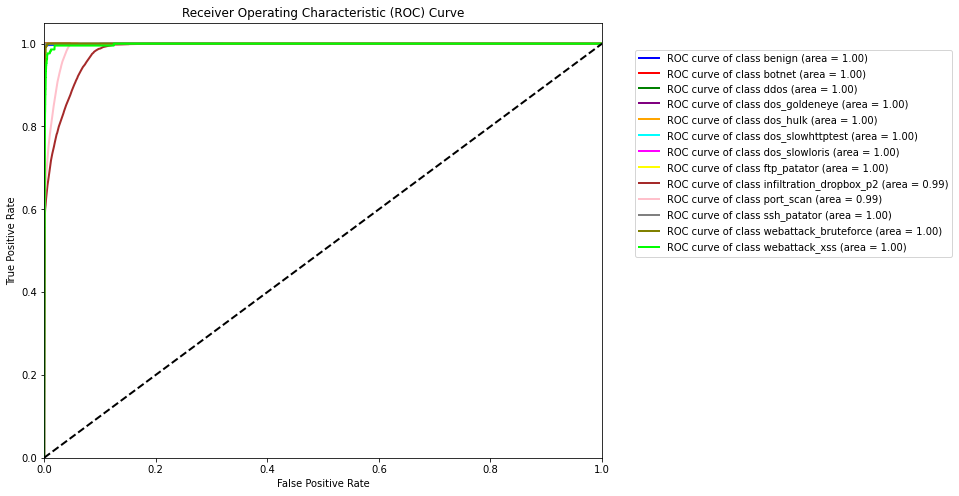

In [206]:
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta', 
                'yellow', 'brown', 'pink', 'gray', 'olive', 'lime'])
for i, color in zip(range(len(le_name_mapping.keys())), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(le_name_mapping_reversed_dict[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.7))
plt.show()

Precision Recall curve

In [210]:
# Compute PR curve curve and ROC area for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(le_name_mapping.keys())):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_pred_prob[:, i])
    average_precision[i] = average_precision_score(y_bin[:, i], y_pred_prob[:, i])

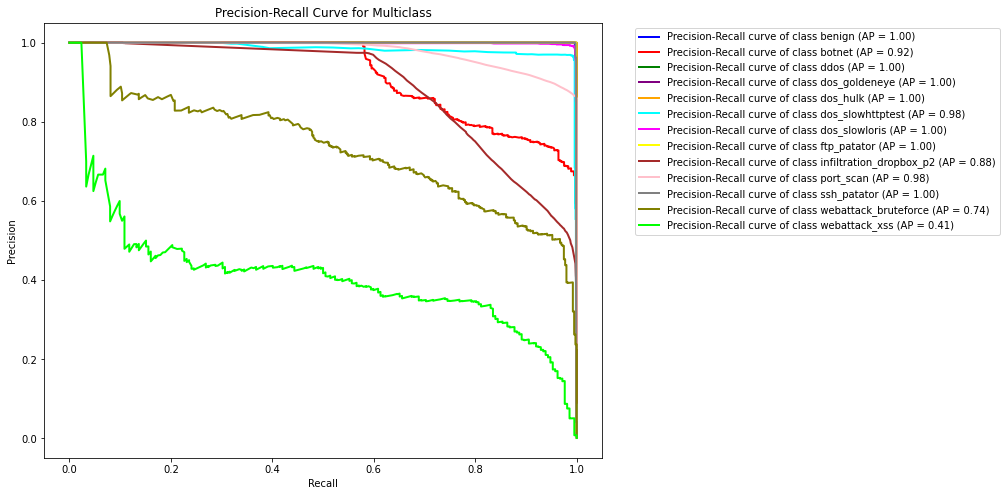

In [213]:
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta', 
                'yellow', 'brown', 'pink', 'gray', 'olive', 'lime'])
for i, color in zip(range(len(le_name_mapping.keys())), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-Recall curve of class {0} (AP = {1:0.2f})'
             ''.format(le_name_mapping_reversed_dict[i], average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiclass')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.75))
plt.show()

# 1 VS All Models

In [295]:
# features = ['flow_duration', 'total_size', 'avg_size', 'std_size',
#        'inter_arrival_mean', 'inter_arrival_std', 'total_fwd_packets',
#        'fwd_flow_duration',
#        'total_fwd_pkt_size', 'avg_fwd_pkt_size', 'std_fwd_pkt_size',
#        'inter_arrival_mean_fwd', 'inter_arrival_std_fwd', 'total_bwd_packets', 'bwd_flow_duration',
#        'total_bwd_pkt_size', 'avg_bwd_pkt_size', 'std_bwd_pkt_size',
#        'inter_arrival_mean_bwd', 'inter_arrival_std_bwd', 'syn_flag_count',
#        'fin_flag_count', 'rst_flag_count', 'psh_flag_count', 'ack_flag_count',
#        'urg_flag_count', 'cwr_flag_count', 'ece_flag_count',
#        'flow_duration_log', 'total_packets']

features = ['total_fwd_packets', 'fwd_flow_duration',
       'total_fwd_pkt_size', 'avg_fwd_pkt_size',
       'inter_arrival_mean_fwd', 'total_bwd_packets', 'bwd_flow_duration',
       'total_bwd_pkt_size', 'avg_bwd_pkt_size',
       'inter_arrival_mean_bwd']

label = ['label']

X = data[features]
y = data[label]

### Selecting Features to be used

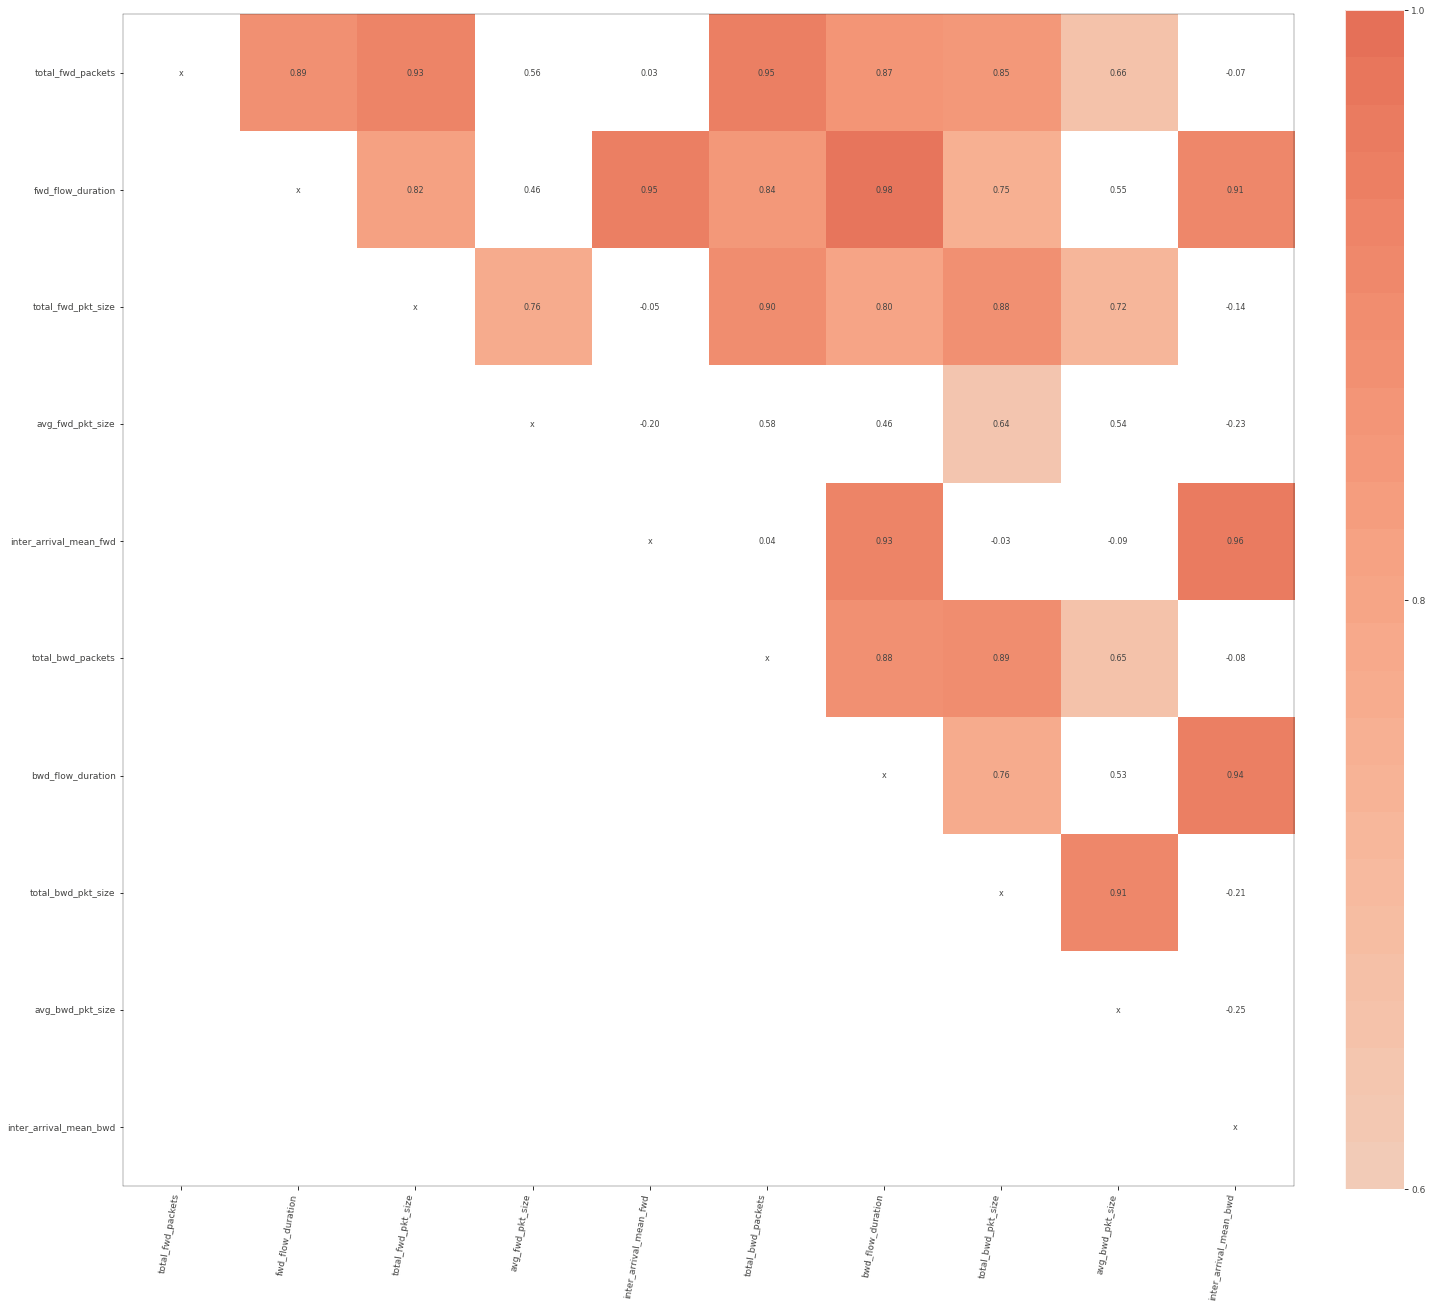

In [216]:
# viz = plot_corr_heatmap(X, figsize=(20,20))

`DDoS` vs `ALL`

In [296]:
def create_binary_class(target_value, label_column):
    return np.where(label_column == target_value, 1, 0)

# Apply the function to create a binary class column
y['label'] = create_binary_class('ddos', y['label'])


/var/folders/68/6vxh_8k15_n5m7tsxrjkzsvm0000gn/T/ipykernel_88845/2632015768.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['label'] = create_binary_class('ddos', y['label'])


In [297]:
X.fillna(0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

/var/folders/68/6vxh_8k15_n5m7tsxrjkzsvm0000gn/T/ipykernel_88845/240940719.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [298]:
# Initialize XGBoost classifier for multiclass classification
xgb_clf = XGBClassifier(
    n_estimators=10,
    max_depth=3)

In [299]:
# Train the classifier
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [300]:
# Predict on the test set
y_pred = xgb_clf.predict(X_test)
y_pred_prob = xgb_clf.predict_proba(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314087
           1       1.00      1.00      1.00     13665

    accuracy                           1.00    327752
   macro avg       1.00      1.00      1.00    327752
weighted avg       1.00      1.00      1.00    327752



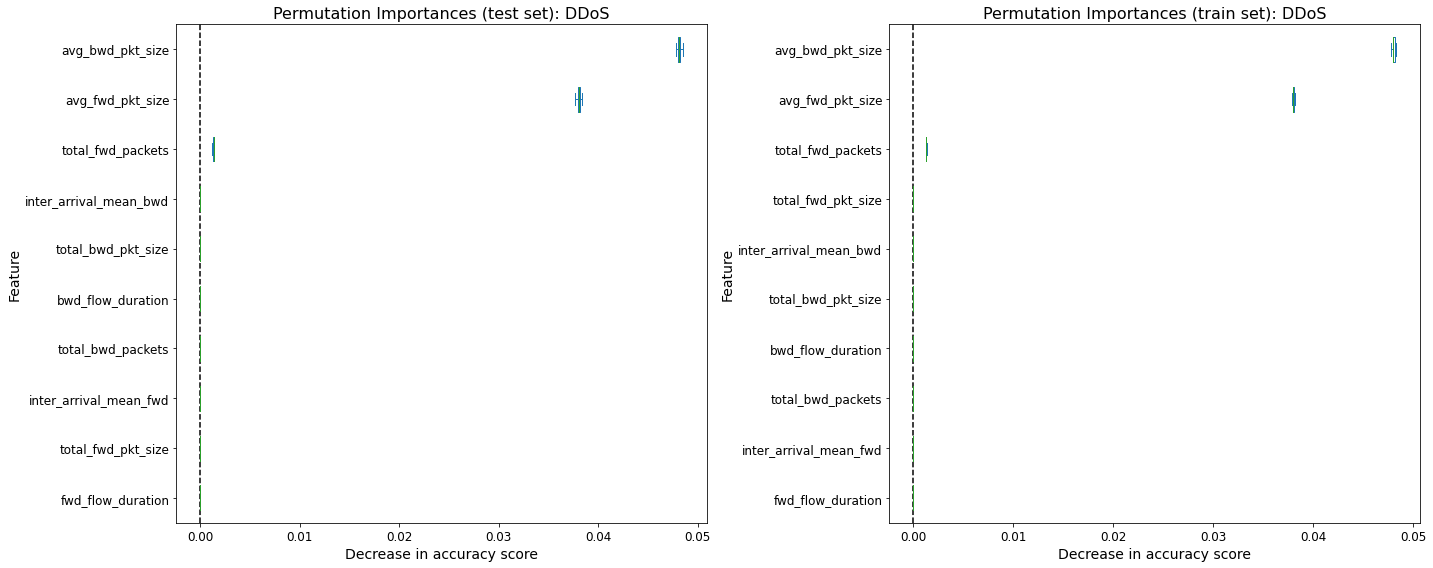

In [301]:
#calculate permutation importance for test data 
result_test = permutation_importance(
    xgb_clf, X_test, y_test, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_test = result_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    result_test.importances[sorted_importances_idx_test].T,
    columns=X_test.columns[sorted_importances_idx_test],
)

#calculate permutation importance for training data 
result_train = permutation_importance(
    xgb_clf, X_train, y_train, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_train = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    result_train.importances[sorted_importances_idx_train].T,
    columns=X.columns[sorted_importances_idx_train],
)

f, axs = plt.subplots(1, 2, figsize=(20, 8))

# Plot for test set
importances_test.plot.box(vert=False, whis=10, ax=axs[0])
axs[0].set_title("Permutation Importances (test set): DDoS", fontsize=16)
axs[0].axvline(x=0, color="k", linestyle="--")
axs[0].set_xlabel("Decrease in accuracy score", fontsize=14)
axs[0].set_ylabel("Feature", fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=12)  # Increase tick label size
axs[0].figure.tight_layout()

importances_train.plot.box(vert=False, whis=10, ax=axs[1])
axs[1].set_title("Permutation Importances (train set): DDoS", fontsize=16)
axs[1].axvline(x=0, color="k", linestyle="--")
axs[1].set_xlabel("Decrease in accuracy score", fontsize=14)
axs[1].set_ylabel("Feature", fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=12)  # Increase tick label size
axs[1].figure.tight_layout()

In [183]:
dependence_matrix = feature_dependence_matrix(X_train,
                          rfrmodel=RandomForestRegressor(n_estimators=50, oob_score=True),
                          rfcmodel=RandomForestClassifier(n_estimators=50, oob_score=True),
                          cat_count=20,
                          zero=0.001,
                          sort_by_dependence=False,
                          n_samples=5000)

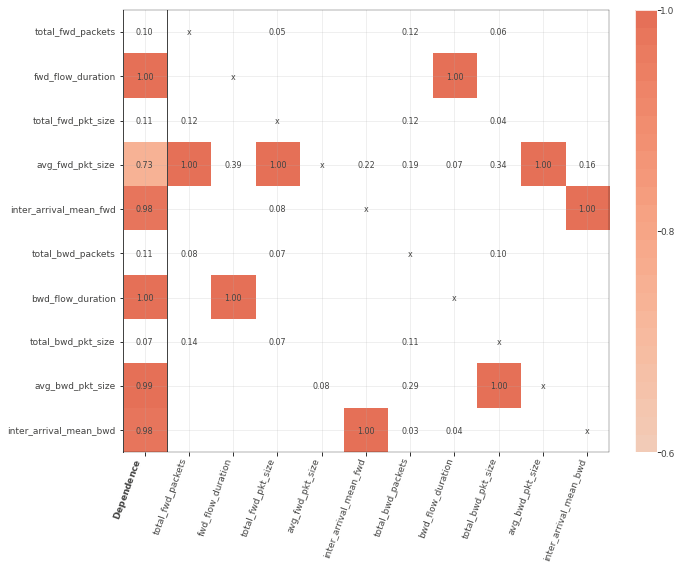

In [184]:
# Set the desired figure size
plt.figure(figsize=(10, 8))  # Adjust width and height as needed

# Plot the dependence heatmap
plot_dependence_heatmap(dependence_matrix)

# Show the plot
plt.show()

`PortScan` vs `ALL`

In [302]:
features = ['total_fwd_packets', 'fwd_flow_duration',
       'total_fwd_pkt_size', 'avg_fwd_pkt_size',
       'inter_arrival_mean_fwd', 'total_bwd_packets', 'bwd_flow_duration',
       'total_bwd_pkt_size', 'avg_bwd_pkt_size',
       'inter_arrival_mean_bwd', 'inter_arrival_mean']

label = ['label']

X = data[features].copy()
y = data[label].copy()

In [303]:
def create_binary_class(target_value, label_column):
    return np.where(label_column == target_value, 1, 0)

# Apply the function to create a binary class column
y['label'] = create_binary_class('port_scan', y['label'])


In [304]:
X.fillna(0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [305]:
# Initialize XGBoost classifier for multiclass classification
xgb_clf = XGBClassifier(
    n_estimators=10,
    max_depth=3)

In [306]:
# Train the classifier
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [307]:
# Predict on the test set
y_pred = xgb_clf.predict(X_test)
y_pred_prob = xgb_clf.predict_proba(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    279649
           1       0.86      0.99      0.92     48103

    accuracy                           0.97    327752
   macro avg       0.93      0.98      0.95    327752
weighted avg       0.98      0.97      0.98    327752



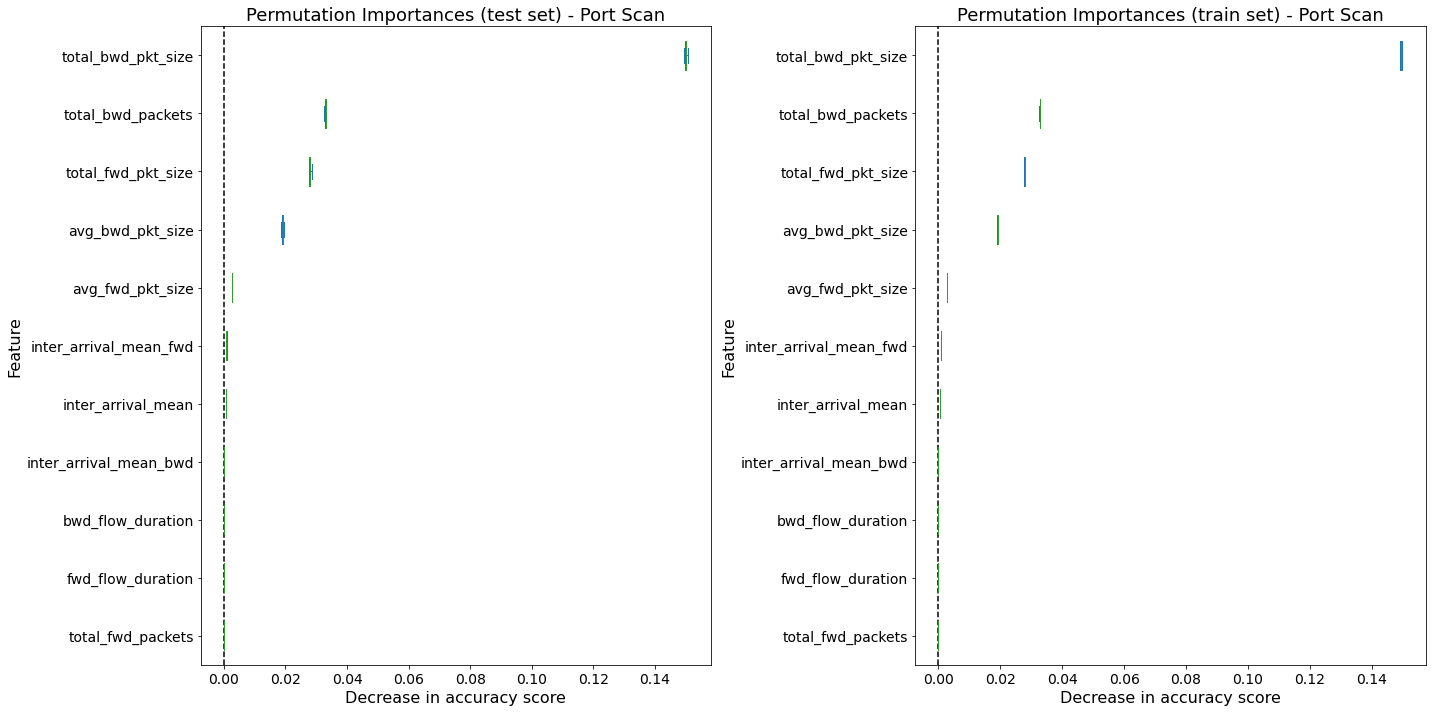

In [310]:
#calculate permutation importance for test data 
result_test = permutation_importance(
    xgb_clf, X_test, y_test, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_test = result_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    result_test.importances[sorted_importances_idx_test].T,
    columns=X_test.columns[sorted_importances_idx_test],
)

#calculate permutation importance for training data 
result_train = permutation_importance(
    xgb_clf, X_train, y_train, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_train = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    result_train.importances[sorted_importances_idx_train].T,
    columns=X.columns[sorted_importances_idx_train],
)

f, axs = plt.subplots(1,2,figsize=(20,10))

# Plot for test set
importances_test.plot.box(vert=False, whis=10, ax=axs[0])
axs[0].set_title("Permutation Importances (test set) - Port Scan", fontsize=18)
axs[0].axvline(x=0, color="k", linestyle="--")
axs[0].set_xlabel("Decrease in accuracy score", fontsize=16)
axs[0].set_ylabel("Feature", fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=14)  # Increase tick label size
axs[0].figure.tight_layout()

# Plot for train set
importances_train.plot.box(vert=False, whis=10, ax=axs[1])
axs[1].set_title("Permutation Importances (train set) - Port Scan", fontsize=18)
axs[1].axvline(x=0, color="k", linestyle="--")
axs[1].set_xlabel("Decrease in accuracy score", fontsize=16)
axs[1].set_ylabel("Feature", fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=14)  # Increase tick label size
axs[1].figure.tight_layout()




`infiltration_dropbox_p2` vs `ALL`

In [311]:
# Making dataset proportional;

filtered_df = data[data['label'] == 'infiltration_dropbox_p2']

num_non_port = len(filtered_df)  # Number of 'port' values
num_total_rows = len(data)


# Get non-'port' values excluding 'port'
non_port_df = data[data['label'] != 'infiltration_dropbox_p2']

# Sample rows from non-'port' values
sampled_non_port_df = non_port_df.sample(n=num_non_port, replace=False)

# Concatenate 'port' rows with sampled non-'port' rows
sampled_df = pd.concat([filtered_df, sampled_non_port_df])

In [312]:
sampled_df[label].value_counts()

label                  
infiltration_dropbox_p2    63413
benign                     48431
port_scan                   9801
ddos                        2704
dos_hulk                     855
dos_goldeneye                479
ftp_patator                  255
dos_slowhttptest             252
dos_slowloris                239
ssh_patator                  202
webattack_bruteforce          86
botnet                        65
webattack_xss                 44
dtype: int64

In [313]:
X = sampled_df[features].copy()
y = sampled_df[label].copy()

In [314]:
def create_binary_class(target_value, label_column):
    return np.where(label_column == target_value, 1, 0)

# Apply the function to create a binary class column
y['label'] = create_binary_class('infiltration_dropbox_p2', y['label'])


In [315]:
X.fillna(0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [316]:
# Initialize XGBoost classifier for multiclass classification
xgb_clf = XGBClassifier(
    n_estimators=10,
    max_depth=3)

# Train the classifier
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [317]:
# Predict on the test set
y_pred = xgb_clf.predict(X_test)
y_pred_prob = xgb_clf.predict_proba(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     18945
           1       0.92      0.98      0.95     19103

    accuracy                           0.95     38048
   macro avg       0.95      0.95      0.95     38048
weighted avg       0.95      0.95      0.95     38048



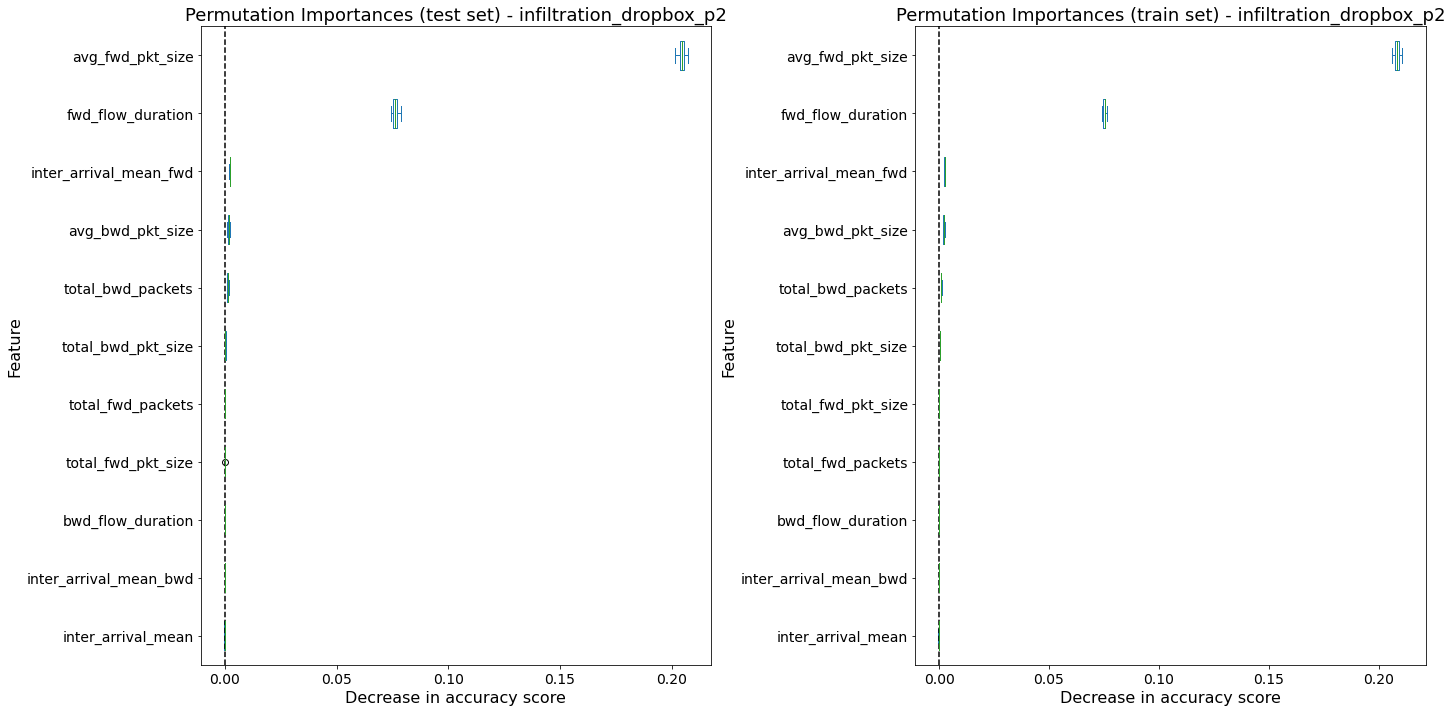

In [319]:
#calculate permutation importance for test data 
result_test = permutation_importance(
    xgb_clf, X_test, y_test, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_test = result_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    result_test.importances[sorted_importances_idx_test].T,
    columns=X_test.columns[sorted_importances_idx_test],
)

#calculate permutation importance for training data 
result_train = permutation_importance(
    xgb_clf, X_train, y_train, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_train = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    result_train.importances[sorted_importances_idx_train].T,
    columns=X.columns[sorted_importances_idx_train],
)

# Create subplots with specified figure size
f, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot for test set
importances_test.plot.box(vert=False, whis=10, ax=axs[0])
axs[0].set_title("Permutation Importances (test set) - infiltration_dropbox_p2", fontsize=18)
axs[0].axvline(x=0, color="k", linestyle="--")
axs[0].set_xlabel("Decrease in accuracy score", fontsize=16)
axs[0].set_ylabel("Feature", fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=14)  # Increase tick label size
axs[0].figure.tight_layout()

# Plot for train set
importances_train.plot.box(vert=False, whis=10, ax=axs[1])
axs[1].set_title("Permutation Importances (train set) - infiltration_dropbox_p2", fontsize=18)
axs[1].axvline(x=0, color="k", linestyle="--")
axs[1].set_xlabel("Decrease in accuracy score", fontsize=16)
axs[1].set_ylabel("Feature", fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=14)  # Increase tick label size
axs[1].figure.tight_layout()

`Botnet` vs `ALL`

In [499]:
# Making dataset proportional;

column = 'botnet'

filtered_df = data[data['label'] == column]

num_non_port = len(filtered_df)  # Number of 'port' values
num_total_rows = len(data)


# Get non-'port' values excluding 'port'
non_port_df = data[data['label'] != column]

# Sample rows from non-'port' values
sampled_non_port_df = non_port_df.sample(n=num_non_port, replace=False)

# Concatenate 'port' rows with sampled non-'port' rows
sampled_df = pd.concat([filtered_df, sampled_non_port_df])

In [500]:
sampled_df['label'].value_counts()

botnet                     1226
benign                      892
port_scan                   174
infiltration_dropbox_p2      68
ddos                         42
dos_goldeneye                13
dos_hulk                     12
ftp_patator                   9
dos_slowhttptest              5
dos_slowloris                 5
ssh_patator                   3
webattack_xss                 2
webattack_bruteforce          1
Name: label, dtype: int64

In [493]:
X = sampled_df[features].copy()
y = sampled_df[label].copy()

In [494]:
def create_binary_class(target_value, label_column):
    return np.where(label_column == target_value, 1, 0)

# Apply the function to create a binary class column
y['label'] = create_binary_class('botnet', y['label'])

In [495]:
X.fillna(0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [496]:
# Initialize XGBoost classifier for multiclass classification
xgb_clf = XGBClassifier(
    n_estimators=50,
    max_depth=5)

# Train the classifier
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [497]:
# Predict on the test set
y_pred = xgb_clf.predict(X_test)
y_pred_prob = xgb_clf.predict_proba(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    327385
           1       0.94      0.64      0.76       367

    accuracy                           1.00    327752
   macro avg       0.97      0.82      0.88    327752
weighted avg       1.00      1.00      1.00    327752



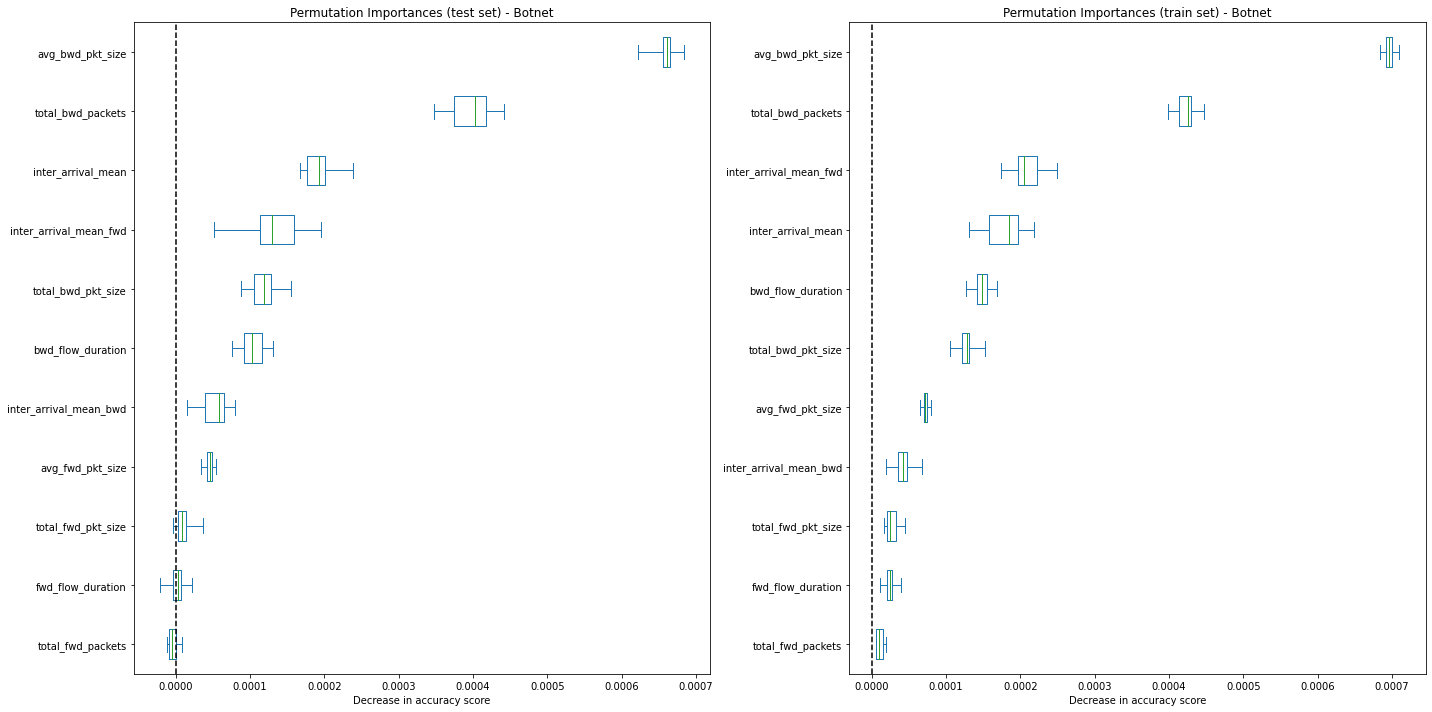

In [498]:
#calculate permutation importance for test data 
result_test = permutation_importance(
    xgb_clf, X_test, y_test, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_test = result_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    result_test.importances[sorted_importances_idx_test].T,
    columns=X_test.columns[sorted_importances_idx_test],
)

#calculate permutation importance for training data 
result_train = permutation_importance(
    xgb_clf, X_train, y_train, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_train = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    result_train.importances[sorted_importances_idx_train].T,
    columns=X.columns[sorted_importances_idx_train],
)

f, axs = plt.subplots(1,2,figsize=(20,10))

importances_test.plot.box(vert=False, whis=10, ax = axs[0])
axs[0].set_title("Permutation Importances (test set) - Botnet")
axs[0].axvline(x=0, color="k", linestyle="--")
axs[0].set_xlabel("Decrease in accuracy score")
axs[0].figure.tight_layout()

importances_train.plot.box(vert=False, whis=10, ax = axs[1])
axs[1].set_title("Permutation Importances (train set) - Botnet")
axs[1].axvline(x=0, color="k", linestyle="--")
axs[1].set_xlabel("Decrease in accuracy score")
axs[1].figure.tight_layout()

`DoS SlowHttp` vs `ALL`

In [285]:
# Making dataset proportional;

column = 'dos_slowhttptest'

filtered_df = data[data['label'] == column]

num_non_port = len(filtered_df)  # Number of 'port' values
num_total_rows = len(data)


# Get non-'port' values excluding 'port'
non_port_df = data[data['label'] != column]

# Sample rows from non-'port' values
sampled_non_port_df = non_port_df.sample(n=num_non_port, replace=False)

# Concatenate 'port' rows with sampled non-'port' rows
sampled_df = pd.concat([filtered_df, sampled_non_port_df])

In [287]:
sampled_df['label'].value_counts()

dos_slowhttptest           4217
benign                     3019
port_scan                   626
infiltration_dropbox_p2     251
ddos                        172
dos_hulk                     65
dos_goldeneye                30
ssh_patator                  20
dos_slowloris                12
ftp_patator                  11
webattack_bruteforce          6
botnet                        4
webattack_xss                 1
Name: label, dtype: int64

In [288]:
X = sampled_df[features].copy()
y = sampled_df[label].copy()

In [289]:
def create_binary_class(target_value, label_column):
    return np.where(label_column == target_value, 1, 0)

# Apply the function to create a binary class column
y['label'] = create_binary_class('infiltration_dropbox_p2', y['label'])

In [290]:
X.fillna(0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [295]:
# Initialize XGBoost classifier for multiclass classification
xgb_clf = XGBClassifier(
    n_estimators=50,
    max_depth=5)

# Train the classifier
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [296]:
# Predict on the test set
y_pred = xgb_clf.predict(X_test)
y_pred_prob = xgb_clf.predict_proba(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2464
           1       0.93      0.57      0.70        67

    accuracy                           0.99      2531
   macro avg       0.96      0.78      0.85      2531
weighted avg       0.99      0.99      0.99      2531



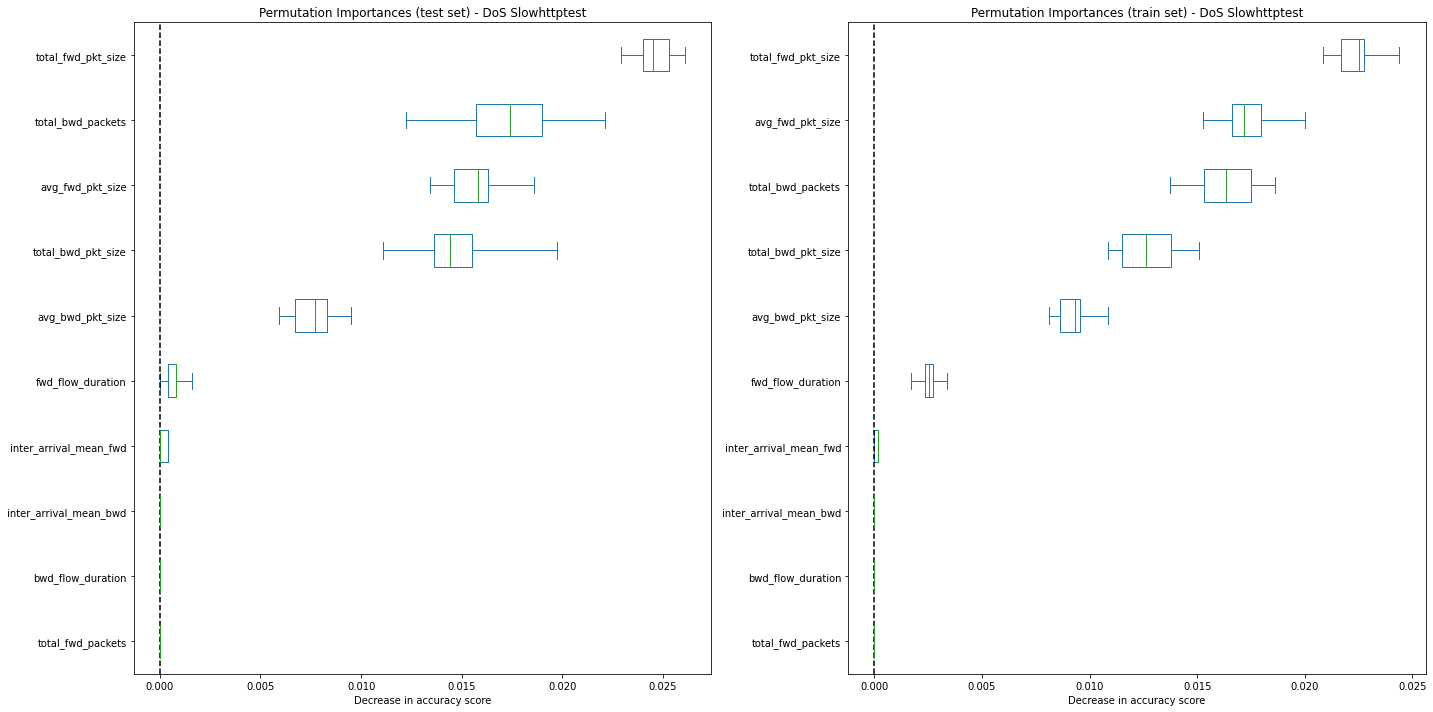

In [297]:
#calculate permutation importance for test data 
result_test = permutation_importance(
    xgb_clf, X_test, y_test, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_test = result_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    result_test.importances[sorted_importances_idx_test].T,
    columns=X_test.columns[sorted_importances_idx_test],
)

#calculate permutation importance for training data 
result_train = permutation_importance(
    xgb_clf, X_train, y_train, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_train = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    result_train.importances[sorted_importances_idx_train].T,
    columns=X.columns[sorted_importances_idx_train],
)

f, axs = plt.subplots(1,2,figsize=(20,10))

importances_test.plot.box(vert=False, whis=10, ax = axs[0])
axs[0].set_title("Permutation Importances (test set) - DoS Slowhttptest")
axs[0].axvline(x=0, color="k", linestyle="--")
axs[0].set_xlabel("Decrease in accuracy score")
axs[0].figure.tight_layout()

importances_train.plot.box(vert=False, whis=10, ax = axs[1])
axs[1].set_title("Permutation Importances (train set) - DoS Slowhttptest")
axs[1].axvline(x=0, color="k", linestyle="--")
axs[1].set_xlabel("Decrease in accuracy score")
axs[1].figure.tight_layout()

# STOP

In [102]:
explainer = shap.Explainer(xgb_clf)
shap_values = explainer.shap_values(X_test)
shap_obj = explainer(shap_values)

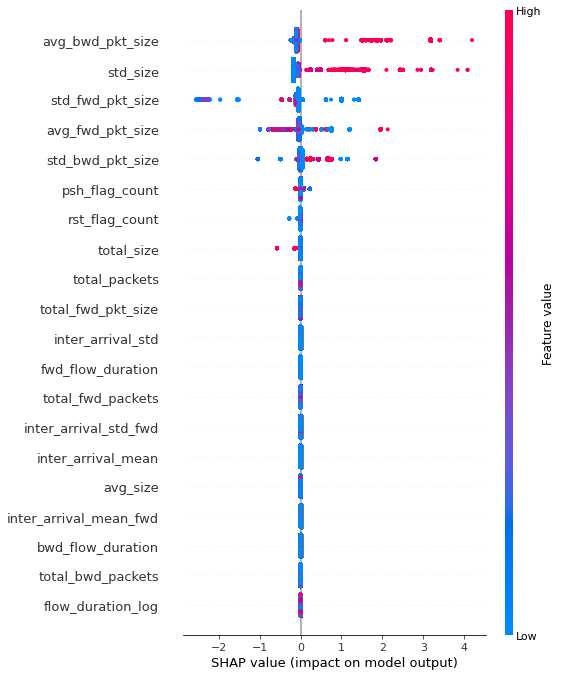

In [105]:
shap.summary_plot(shap_values, X_test)

## SHAP Analysis

In [419]:
data_filtered = data[data['label'].isin(['infiltration_dropbox_p2', 'port_scan'])].copy()
X = data_filtered[features]
y = data_filtered[label]

le = LabelEncoder()
y_encoded = le.fit_transform(y)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

/Users/danieldacosta/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [421]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [424]:
# Initialize XGBoost classifier for multiclass classification
xgb_clf = XGBClassifier(
    n_estimators=10,
    max_depth=3)
    # objective='multi:softmax')

In [425]:
# Train the classifier
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [426]:
# Predict on the test set
y_pred = xgb_clf.predict(X_test)
y_pred_prob = xgb_clf.predict_proba(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.57      0.73     18842
           1       0.86      1.00      0.92     48183

    accuracy                           0.88     67025
   macro avg       0.92      0.79      0.82     67025
weighted avg       0.89      0.88      0.87     67025



In [439]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_train)
shap_obj = explainer(shap_values)

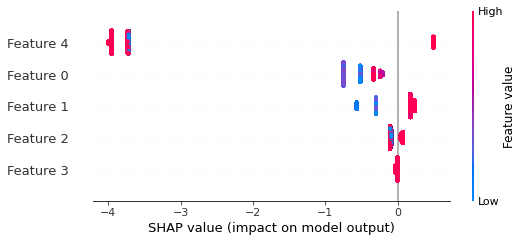

In [440]:
shap.plots.beeswarm(shap_obj)

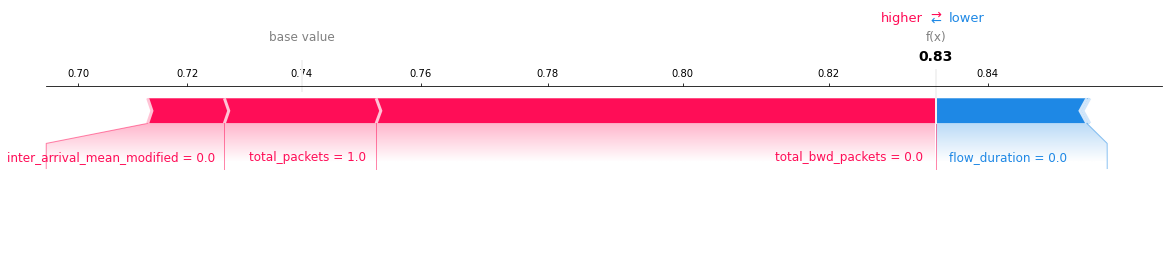

In [443]:
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    X_test.iloc[0],
    link="logit",
    matplotlib=True,
)

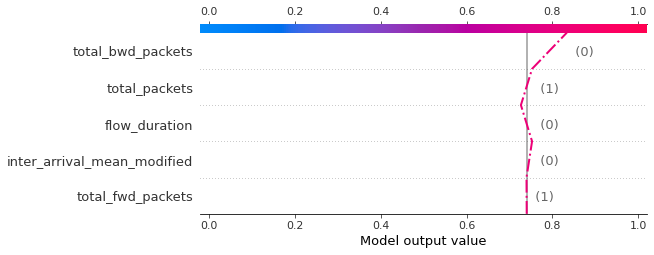

In [445]:
shap.decision_plot(
    explainer.expected_value,
    shap_values[0],
    X_test.iloc[0],
    link="logit",
    highlight=0
)

 # STOP HERE FOR NOW

In [ ]:
data['total_packets'] = data['total_bwd_packets'] + data['total_fwd_packets']

In [ ]:
plt.figure(figsize=(30, 6))
sns.boxplot(x='label', y='total_packets', data=data, showfliers=False)
plt.title('Box Plot of flow_duration by label')
plt.xlabel('Label')
plt.ylabel('total_packets')
plt.show()

Box plots analysis

In [ ]:
plt.figure(figsize=(30, 6))
sns.boxplot(x='label', y='flow_duration', data=df, showfliers=False)
plt.title('Box Plot of flow_duration by label')
plt.xlabel('Label')
plt.ylabel('fin_flag_count')
plt.show()

In [ ]:
plt.figure(figsize=(30, 6))
sns.boxplot(x='label', y='total_size', data=df, showfliers=False)
plt.title('Box Plot of total_size by label')
plt.xlabel('Label')
plt.ylabel('rst_flag_count')
plt.show()

- Handling NaNs

In [ ]:
df.isnull().sum()*100/df.shape[0]

In [ ]:
df_benign = df[df['label'] == 'benign'].copy()
df_benign.isnull().sum()*100/df_benign.shape[0]

In [ ]:
# # Get only the numeric columns
# numeric_cols = df.select_dtypes(include=['number'])

# # Fill NaN values with the mean of each numeric column
# df[numeric_cols.columns] = numeric_cols.fillna(numeric_cols.mean())

- Convert datetime features -> get the Unix timestamp.

In [ ]:
df['first_timestamp'].value_counts()

In [ ]:
# df['first_timestamp'] = pd.to_datetime(df['first_timestamp']).astype(int) / 10**9
# df['first_timestamp_fwd'] = pd.to_datetime(df['first_timestamp_fwd']).astype(int) / 10**9


# df['last_timestamp_bwd'] = pd.to_datetime(df['last_timestamp_bwd']).astype(int) / 10**9

# df['last_timestamp'] = pd.to_datetime(df['last_timestamp']).astype(int) / 10**9

# df['first_timestamp_bwd'] = pd.to_datetime(df['first_timestamp_bwd']).astype(int) / 10**9

# df['last_timestamp_fwd'] = pd.to_datetime(df['last_timestamp_fwd']).astype(int) / 10**9


# Dataframe - Rescaled Proportions

In [ ]:
original_total = 2187304

In [ ]:
benign = 1807787
ddos = 320269
portscan = 57305
botnet = 1943

In [ ]:
print('Benign %: ', benign/original_total)
print('Ddos %: ', ddos/original_total)
print('PortScan %: ', portscan/original_total)
print('Botnet %: ', botnet/original_total)

In [ ]:
benign_count = df['label'].value_counts().benign
ddos_count = int(np.floor(df['label'].value_counts().benign*ddos/original_total))
portscan_count = int(np.floor(df['label'].value_counts().benign*portscan/original_total))
botnet_count = int(np.floor(df['label'].value_counts().benign*botnet/original_total))

In [ ]:
df_resampled = pd.concat([
    df[df['label'] == 'benign'],
    df[df['label'] == 'ddos'].sample(ddos_count, random_state=42),
    df[df['label'] == 'port_scan'].sample(portscan_count, random_state=42),
    df[df['label'] == 'botnet'].sample(botnet_count, random_state=42)
])

In [ ]:
print(df_resampled['label'].value_counts())
# Compute proportions
proportions = df_resampled['label'].value_counts()*100 / len(df_resampled)

# Display proportions
print(proportions)

# Split dataset

In [ ]:
# df = df_resampled

In [ ]:
df.head()

In [ ]:
# Removing non-numerical features
features = list(set(df.columns) -\
    set(['label', 'flow_id', 'src_ip', 'dst_port', 'dst_ip', 'sport', 'pkt_lens', 'fwd_inter_arrival_times', 'fwd_arrival_times',
         'bwd_arrival_times', 'arrival_times', 'bwd_pkt_lens', 'inter_arrival_times', 'fwd_pkt_lens', 'bwd_inter_arrival_times']) -\
              set(['first_timestamp', 'last_timestamp', 'first_timestamp_fwd', 'last_timestamp_fwd', 'first_timestamp_bwd', 'last_timestamp_bwd']))
label = ['label']

In [ ]:
features

# Split dataset

In [ ]:
# # COLUMN len_per_sec has INF

# df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df['len_per_sec'].fillna(df['len_per_sec'].mean(), inplace=True)

In [ ]:
X.isnull().sum()

In [ ]:


# X = df[features]
# # X = df[['fin_flag_count', 'rst_flag_count']]
# y = df['label']

# Droping NaN
X = df[ features+ ['label']].dropna(how='any')
y = X[label]
X = X[features]



label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Binarize the labels
y_bin = label_binarize(y_encoded, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])

In [ ]:
X.shape[0]

# Model

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from itertools import cycle

- Logistic Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.3, random_state=42)

In [ ]:
# Create the classifier
clf = OneVsRestClassifier(Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression(max_iter=10000))]))

In [ ]:
# Train the classifier
clf.fit(X_train, y_train)

In [ ]:
y_score = clf.predict_proba(X_test)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
scores = cross_val_score(clf, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

- XGB

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [ ]:
y_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])

In [ ]:
# Initialize XGBoost classifier for multiclass classification
xgb_clf = XGBClassifier(
    n_estimators=10,
    max_depth=3,
    objective='multi:softmax')#, num_class=len(set(y_train)))

In [ ]:
set(y_train)

In [ ]:
# Train the classifier
xgb_clf.fit(X_train, y_train)

In [ ]:
xgb_clf.classes_

In [ ]:
# Predict on the test set
y_pred = xgb_clf.predict(X_test)
y_pred_prob = xgb_clf.predict_proba(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Plot feature importance
xgb.plot_importance(xgb_clf)
plt.show()

In [ ]:
scores = cross_val_score(xgb_clf, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [ ]:
# Get unique elements and their counts
unique_elements, counts = np.unique(y_test, return_counts=True)

# Zip them together for readability
element_counts = dict(zip(unique_elements, counts))

# Print the counts
print("Element Counts:")
for element, count in element_counts.items():
    print(f"{element}: {count}")

In [ ]:
# Get unique elements and their counts
unique_elements, counts = np.unique(y_pred, return_counts=True)

# Zip them together for readability
element_counts = dict(zip(unique_elements, counts))

# Print the counts
print("Element Counts:")
for element, count in element_counts.items():
    print(f"{element}: {count}")

In [ ]:
# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

- RF

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [ ]:
feature_names = list(X_train.columns)

In [ ]:
y_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

In [ ]:
# Initialize Random Forest classifier for multiclass classification
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
# Train the classifier
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_clf.predict(X_test)

y_pred_prob = rf_clf.predict_proba(X_test)

In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)  # Replace with original feature names and rotate x-axis labels by 45 degrees
plt.xlim([-1, X.shape[1]])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
scores = cross_val_score(rf_clf, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))